# Using Darts Models to Compare Different ML Algorithms to Predict Wind Direction and Speed on 2-hour lag

This is a continuation from the [EDA findings](https://github.com/tosmartak/darts-model-for-wind-speed-direction-prediction/blob/push-files/notebooks/EDA.ipynb).

In [ ]:
!pip install -q darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.9/693.9 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 71.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 16.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.4/372.4 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 5.4 MB/s eta

In [ ]:
%matplotlib inline 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from datetime import datetime
import time

from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values
from darts.metrics import rmse, mae, r2_score
from darts.models import CatBoostModel, LinearRegressionModel, RandomForest, LightGBMModel, XGBModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from sklearn.preprocessing import MinMaxScaler
from darts.explainability import ShapExplainer, ExplainabilityResult

plt.rcParams["figure.figsize"] = (20, 5)

In [ ]:
# Select columns to use
use_col = ['Timestamp', 'GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WSgust', 'BP', 'Precipitation', 'TModA', 'TModB', 'WS', 'WD']

# load Bauchi data
path = '/content/drive/MyDrive/DS-ML projects/Predicting Wind Direction and Speed/data/solar-measurements_nigeria-bauchi_qc.csv'
df = pd.read_csv(path, skiprows=[1], encoding='unicode_escape', usecols = use_col, parse_dates = ['Timestamp'], index_col = 'Timestamp')
df = df.replace("NAN", np.nan)
# drop the last row
df = df.drop(df.index[-1])

In [ ]:
df.head()

GHI  DNI  DHI  ModA  ...   BP  Precipitation  TModA  TModB
Timestamp                                 ...                                  
2021-09-20 00:01:00 -1.2 -0.3 -1.4   0.0  ...  948            0.0   21.4   21.6
2021-09-20 00:02:00 -1.2 -0.3 -1.5   0.0  ...  948            0.0   21.4   21.6
2021-09-20 00:03:00 -1.2 -0.3 -1.4   0.0  ...  948            0.0   21.4   21.6
2021-09-20 00:04:00 -1.2 -0.3 -1.5   0.0  ...  948            0.0   21.4   21.6
2021-09-20 00:05:00 -1.2 -0.3 -1.5   0.0  ...  948            0.0   21.4   21.6

[5 rows x 14 columns]

In [ ]:
# Define function to calculate circular mean of wind direction
def circ_mean(x):
    x = np.radians(x)
    x_cos = np.mean(np.cos(x))
    x_sin = np.mean(np.sin(x))
    x_mean = np.arctan2(x_sin, x_cos)
    x_mean = np.degrees(x_mean) % 360
    return x_mean

# # CALCULATE WIND DIRECTION AVERAGE (by Kanda) https://gist.github.com/jmquintana79/dbca875cbe0c08154c8eca670e74fddf
# def circ_mean(D0:'np array') -> float:
#     """
#     Calculate wind direction average.
#     D0 -- list of angles to be averaged.
#     return -- average.
#     """
#     import numpy as np

#     ph = D0/180*np.pi
#     Ds = np.sin(ph)
#     Dc = np.cos(ph)

#     wd0 = 180/np.pi*np.arctan2(Ds.mean(),Dc.mean())
#     if wd0 < 0:            
#         wd0 += 360
#     mean_wd = wd0
#     return mean_wd

# Resample df to 1-hour intervals, calculating mean of selected column
df_hourly = df.resample('1H').agg({'GHI': ['mean'],
                                   'DNI': ['mean'],
                                   'DHI': ['mean'],
                                   'ModA': ['mean'],
                                   'ModB': ['mean'],
                                   'Tamb': ['mean'],
                                   'RH': ['mean'],
                                   'WSgust': ['mean'],
                                   'BP': ['mean'],
                                   'Precipitation': 'sum',
                                   'TModA': ['mean'],
                                   'TModB': ['mean'],
                                   'WS': ['mean'],
                                   'WD': circ_mean})

# Flatten column headers for df_hourly
df_hourly.columns = [f'{col[0]}_{col[1].upper()}' for col in df_hourly.columns]

# Based on our EDA findings, engineer features for hour and month
df_hourly["hour"] = df_hourly.index.hour
df_hourly["month"] = df_hourly.index.month

# reset index
df_hourly.reset_index(inplace=True)

# Round the float columns to 1 decimal place in df_hourly
float_cols = df_hourly.select_dtypes(include='float').columns
df_hourly[float_cols] = df_hourly[float_cols].round(1)

# Set Timestamp column as index and rename it
df_hourly = df_hourly.set_index('Timestamp')

# View the first 5 rows of df_hourly
df_hourly.head()

GHI_MEAN  DNI_MEAN  DHI_MEAN  ModA_MEAN  ModB_MEAN  \
Timestamp                                                                 
2021-09-20 00:00:00      -1.0      -0.2      -1.2        0.0        0.0   
2021-09-20 01:00:00      -0.9      -0.2      -1.2        0.0        0.0   
2021-09-20 02:00:00      -1.4      -0.4      -1.6        0.0        0.0   
2021-09-20 03:00:00      -1.8      -0.4      -2.0        0.0        0.0   
2021-09-20 04:00:00      -1.9      -0.4      -2.1        0.0        0.0   

                     Tamb_MEAN  RH_MEAN  WSgust_MEAN  BP_MEAN  \
Timestamp                                                       
2021-09-20 00:00:00       22.2     93.8          0.5    947.5   
2021-09-20 01:00:00       22.4     92.9          0.7    947.0   
2021-09-20 02:00:00       21.6     93.9          0.5    946.3   
2021-09-20 03:00:00       20.6     96.2          0.8    945.7   
2021-09-20 04:00:00       20.9     95.4          1.1    945.6   

                     Precipitation_SUM  TModA_MEAN  TModB_MEAN  WS_MEAN  \
Timestamp                                                                 
2021-09-20 00:00:00                0.0        21.5        21.8      0.3   
2021-09-20 01:00:00                0.0        21.8        22.2      0.4   
2021-09-20 02:00:00                0.0        20.3        20.6      0.3   
2021-09-20 03:00:00                0.0        19.5        19.9      0.5   
2021-09-20 04:00:00                0.0        19.9        20.1      0.7   

                     WD_CIRC_MEAN  hour  month  
Timestamp                                       
2021-09-20 00:00:00         314.6     0      9  
2021-09-20 01:00:00         287.2     1      9  
2021-09-20 02:00:00         304.1     2      9  
2021-09-20 03:00:00         276.1     3      9  
2021-09-20 04:00:00         255.7     4      9

In [ ]:
df_hourly.tail()

GHI_MEAN  DNI_MEAN  DHI_MEAN  ModA_MEAN  ModB_MEAN  \
Timestamp                                                                 
2022-09-19 19:00:00      -3.0      -0.3      -2.7        0.0        0.0   
2022-09-19 20:00:00      -2.9      -0.3      -2.6        0.0        0.0   
2022-09-19 21:00:00      -2.5      -0.3      -2.2        0.0        0.0   
2022-09-19 22:00:00      -2.5      -0.2      -2.3        0.0        0.0   
2022-09-19 23:00:00      -2.9      -0.3      -2.6        0.0        0.0   

                     Tamb_MEAN  RH_MEAN  WSgust_MEAN  BP_MEAN  \
Timestamp                                                       
2022-09-19 19:00:00       21.1     91.6          1.6    947.0   
2022-09-19 20:00:00       20.6     92.9          1.6    947.8   
2022-09-19 21:00:00       20.6     93.6          2.3    948.7   
2022-09-19 22:00:00       20.9     93.2          1.8    949.0   
2022-09-19 23:00:00       20.4     93.9          0.3    949.0   

                     Precipitation_SUM  TModA_MEAN  TModB_MEAN  WS_MEAN  \
Timestamp                                                                 
2022-09-19 19:00:00                0.0        19.9        20.4      0.8   
2022-09-19 20:00:00                0.0        19.7        20.0      0.7   
2022-09-19 21:00:00                0.0        20.0        20.3      1.5   
2022-09-19 22:00:00                0.0        20.2        20.7      1.0   
2022-09-19 23:00:00                0.0        19.2        19.7      0.1   

                     WD_CIRC_MEAN  hour  month  
Timestamp                                       
2022-09-19 19:00:00         125.8    19      9  
2022-09-19 20:00:00         185.8    20      9  
2022-09-19 21:00:00         181.3    21      9  
2022-09-19 22:00:00         164.9    22      9  
2022-09-19 23:00:00           0.3    23      9

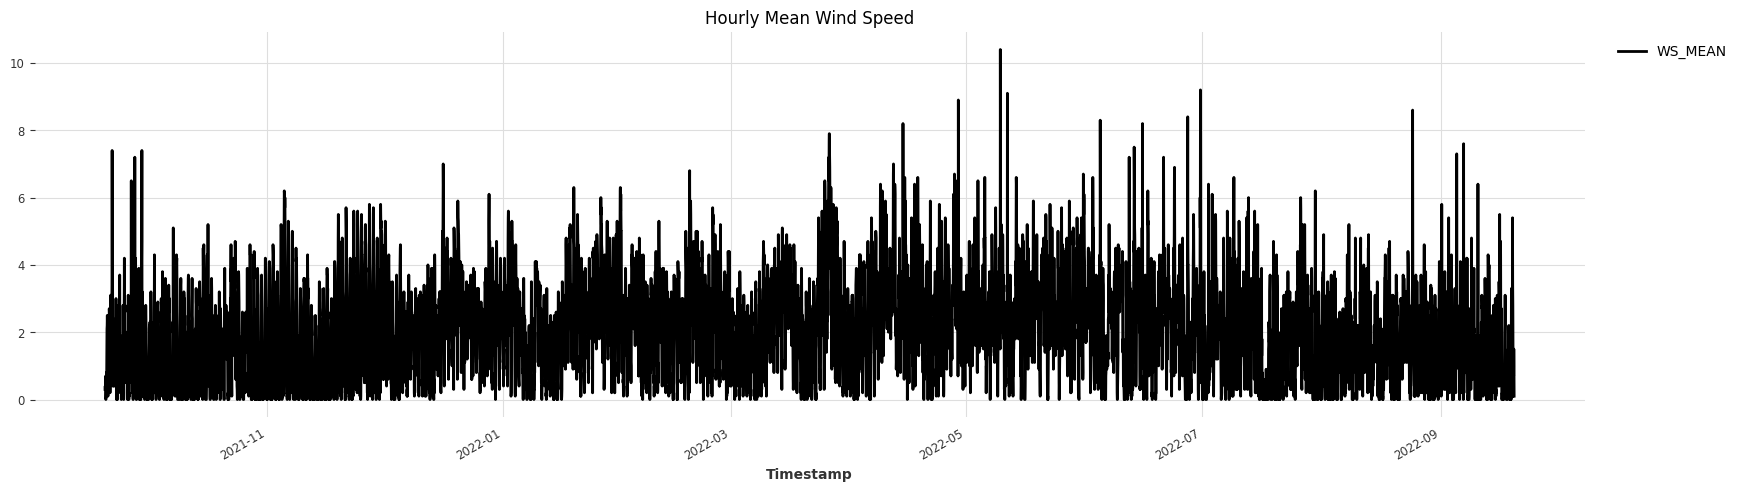

In [ ]:
# Converting Wind Speed Max to Timeseries Object
# since we have our timestamp already as index, we won't use time_col in our .from_dataframe()
ts_WS = TimeSeries.from_dataframe(df_hourly, value_cols= ['WS_MEAN'], freq='H')

# Plot Wind Speed Over time
ts_WS.plot()
plt.title("Hourly Mean Wind Speed")
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper right')

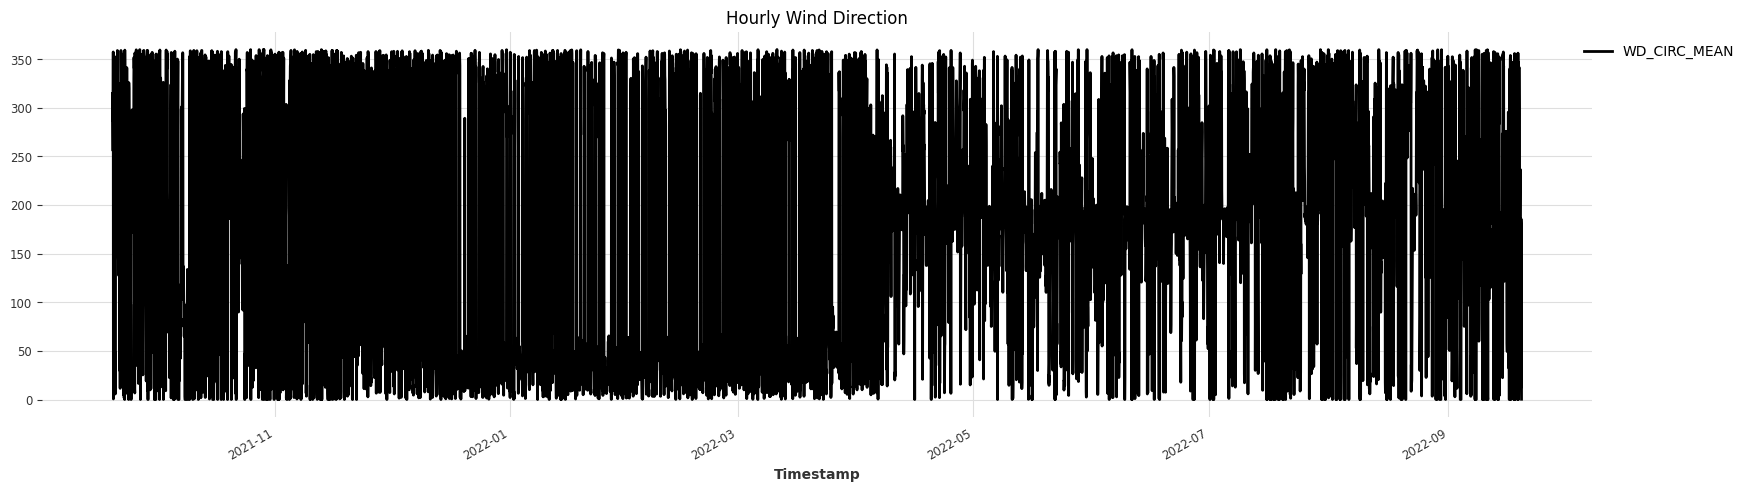

In [ ]:
# Converting Wind Direction to Timeseries Object
# since we have our timestamp already as index, we won't use time_col in our .from_dataframe()
ts_WD = TimeSeries.from_dataframe(df_hourly, value_cols= ['WD_CIRC_MEAN'], freq='H')

# Plotting Wind Direction over Time
ts_WD.plot()
plt.title("Hourly Wind Direction")
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper right')

In [ ]:
def display_forecast(prediction_series, transformed_series, model_name, start_date=None):
    if start_date:
        transformed_series = transformed_series.drop_before(start_date)
    transformed_series.univariate_component(0).plot(label="Actual Values")
    prediction_series.plot(label="Predicted Values")
    rmse_value = rmse(transformed_series.univariate_component(0), prediction_series)
    mae_value = mae(transformed_series.univariate_component(0), prediction_series)
    plt.title(
        (model_name + "\n" + "RMSE: {:.2f}, \nMAE: {:.2f}".format(rmse_value, mae_value))
    )
    plt.legend(bbox_to_anchor=(1.12, 1), loc='upper right')
    return rmse_value, mae_value

In [ ]:
# Define a function to fill in missing values using linear interpolation and scale the data
def transform_series(data_series, filler, scaler):
  filler = filler
  scaler = scaler
  transformed_series = scaler.fit_transform(filler.transform(data_series)).astype(np.float32)
  return scaler, transformed_series

In [ ]:
# Define function to split series by date
def split_data(transformed_series, date_split=None, chart_title=None):
  train_ts, val_ts = transformed_series.split_after(pd.Timestamp(date_split))
  train_ts.plot(label="training")
  val_ts.plot(label="validation")
  plt.legend(bbox_to_anchor=(1.1, 1), loc='upper right')
  plt.title(chart_title)
  return train_ts, val_ts

In [ ]:
# Define function to split series by date
def split_cov(transformed_series, date_split=None):
  train_ts, val_ts = transformed_series.split_after(pd.Timestamp(date_split))
  return train_ts, val_ts

In [ ]:
# Define post prediction date for model
pred_after = "20220801"

Percentage of validation data: 13.69%


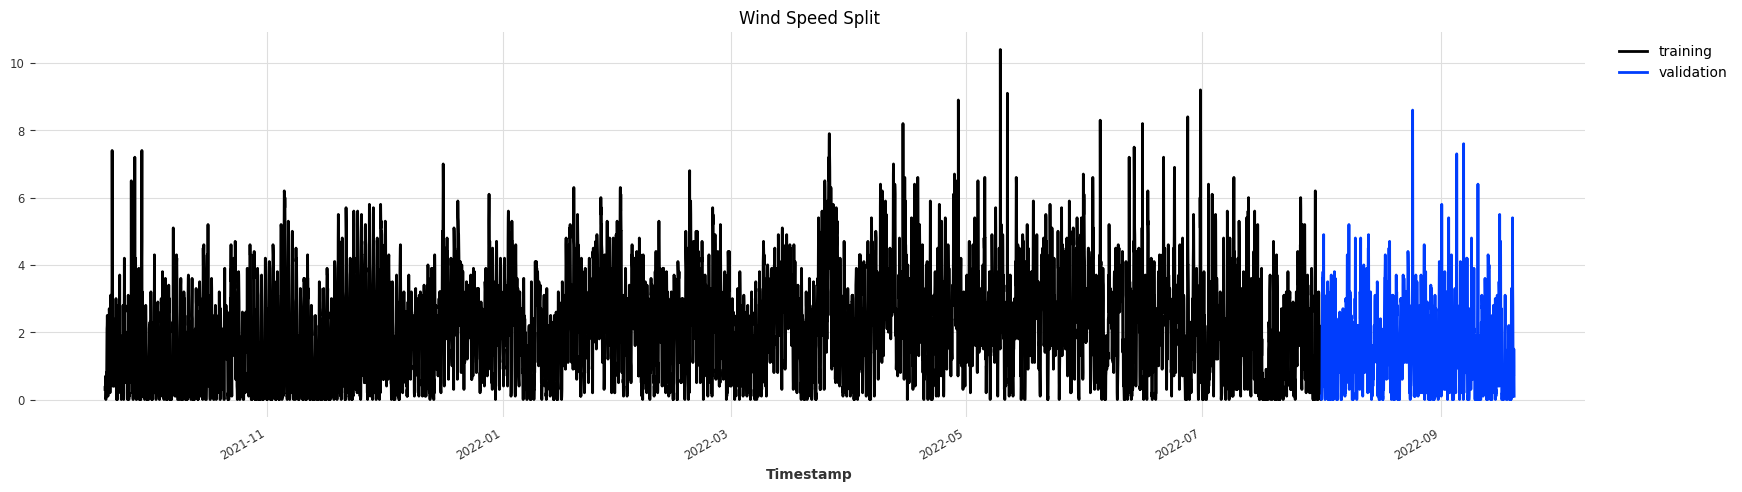

In [ ]:
# transform WS Series
# WS_Scaler, transformed_WS_Series = transform_series(data_series=ts_WS, filler = MissingValuesFiller(), scaler = Scaler())

# Split into training and validation and plot
train_WS_ts, val_WS_ts = split_data(ts_WS, date_split = pred_after, chart_title="Wind Speed Split")

# Calculate the percentage of validation data
pct_val = len(val_WS_ts) / len(ts_WS) * 100
print(f"Percentage of validation data: {pct_val:.2f}%")

Percentage of validation data: 13.69%


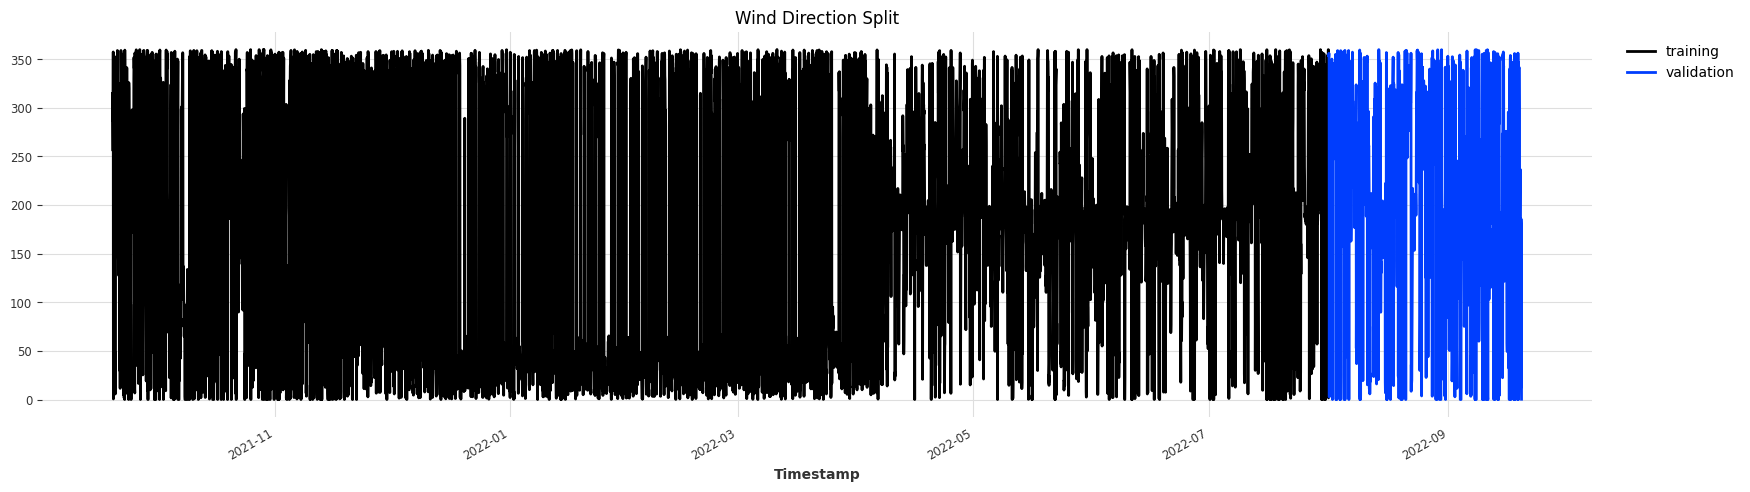

In [ ]:
# transform WD Series
# WD_Scaler, transformed_WD_Series = transform_series(data_series=ts_WD, filler = MissingValuesFiller(), scaler = Scaler())

# Split into training and validation and plot
train_WD_ts, val_WD_ts = split_data(ts_WD, date_split = pred_after, chart_title="Wind Direction Split")

# Calculate the percentage of validation data
pct_val = len(val_WD_ts) / len(ts_WD) * 100
print(f"Percentage of validation data: {pct_val:.2f}%")

## Setting up Functions and Inputs for Prediction
Before we commence with training our models, generating predictions and evaluating the model, we will go ahead to preprocess our covariate data, define our functions for covariate and non-covariate predictions, and define some of our inputs.

In [ ]:
# Define lag for the prediction
lag = 2

# Initialize the table to append our evaluation results as we fit each model
model_results = pd.DataFrame(columns=[])

In [ ]:
# Converting wind speed covariates to Timeseries Object
ts_cov_ws = TimeSeries.from_dataframe(df_hourly.drop(['WS_MEAN'], axis=1), freq='H')

# transform Wind Speed Covariates
WS_cov_scaler, ts_cov_ws = transform_series(data_series=ts_cov_ws, filler = MissingValuesFiller(), scaler = Scaler())

# Split Wind Speed Covariates
train_ws_cov, val_ws_cov = split_cov(ts_cov_ws, date_split=pred_after)


# Converting wind direction covariates to Timeseries Object
ts_cov_wd = TimeSeries.from_dataframe(df_hourly.drop(['WD_CIRC_MEAN'], axis=1), freq='H')

# transform Wind Direction Covariates
WD_cov_scaler, ts_cov_wd = transform_series(data_series=ts_cov_wd, filler = MissingValuesFiller(), scaler = Scaler())

# Split Wind Direction Covariates
train_wd_cov, val_wd_cov = split_cov(ts_cov_wd, date_split=pred_after)

In [ ]:
# define function to train and evaluate any model
def train_eval_model(model, series, train_series, pred_after, model_name, target_desc, chart_title, past_cov=None, clip_min=None, clip_max=None, summary_df=None):
  
  # Fit model
  model = model.fit(train_series, past_covariates = past_cov)

  # log start time
  start_time = time.time()

  # Generate Predictions
  predictions = model.historical_forecasts(series, start=pd.Timestamp(pred_after), retrain=False, past_covariates = past_cov)

  # Clip predictions
  predictions = TimeSeries.from_times_and_values(predictions.time_index, np.clip(predictions.values(), clip_min, clip_max))

  # log end time
  end_time = time.time()

  # calculate elapsed time
  elapsed_time = end_time - start_time

  # display forecast and evaluation
  rmse, mae = display_forecast(predictions, series, chart_title, start_date=pd.Timestamp(pred_after))

  # Create summary dataframe
  summary = pd.DataFrame({'Model Name': [model_name],
                          'Target': [target_desc],
                          'RMSE': [rmse],
                          'MAE': [mae],
                          'Elapsed Time(s)': [elapsed_time]})
  
  # If summary_df already exists, append new row, else create summary_df
  summary_df = pd.concat([summary_df, summary], ignore_index=True)
  
  return model, summary_df

In [ ]:
# define function to evaluate any model only
def eval_model(model, series, pred_after, past_cov=None, model_name=None, target_desc=None, chart_title=None, clip_min=None, clip_max=None, summary_df=None):

  # log start time
  start_time = time.time()
  
  # Generate Predictions
  predictions = model.historical_forecasts(series, start=pd.Timestamp(pred_after), retrain=False, past_covariates = past_cov)

  # Clip predictions
  predictions = TimeSeries.from_times_and_values(predictions.time_index, np.clip(predictions.values(), clip_min, clip_max))

  # log end time
  end_time = time.time()

  # calculate elapsed time
  elapsed_time = end_time - start_time

  # display forecast and evaluation
  rmse, mae = display_forecast(predictions, series, chart_title, start_date=pd.Timestamp(pred_after))

  # Create summary dataframe
  summary = pd.DataFrame({'Model Name': [model_name],
                          'Target': [target_desc],
                          'RMSE': [rmse],
                          'MAE': [mae],
                          'Elapsed Time(s)': [elapsed_time]})
  
  # If summary_df already exists, append new row, else create summary_df
  summary_df = pd.concat([summary_df, summary], ignore_index=True)
  
  return model, summary_df

## Predicting Wind Speed and Wind Direction Using Different Models from Darts
We will be trying out multiple models, since Darts makes it easy to evaluate each model to see how it performs on the target label. For some of the models, we will test them without the covariates, and some with the covariates, and some both, depending on the model.

### Using Linear Regression Model

In [ ]:
# Define the Linear Regression Model without Covariates on 2-hour lag
lr_nocov_model = LinearRegressionModel(lags=lag)

# Define the Linear Regression for covariates inclusion
lr_cov_model = LinearRegressionModel(lags=lag, lags_past_covariates=lag)

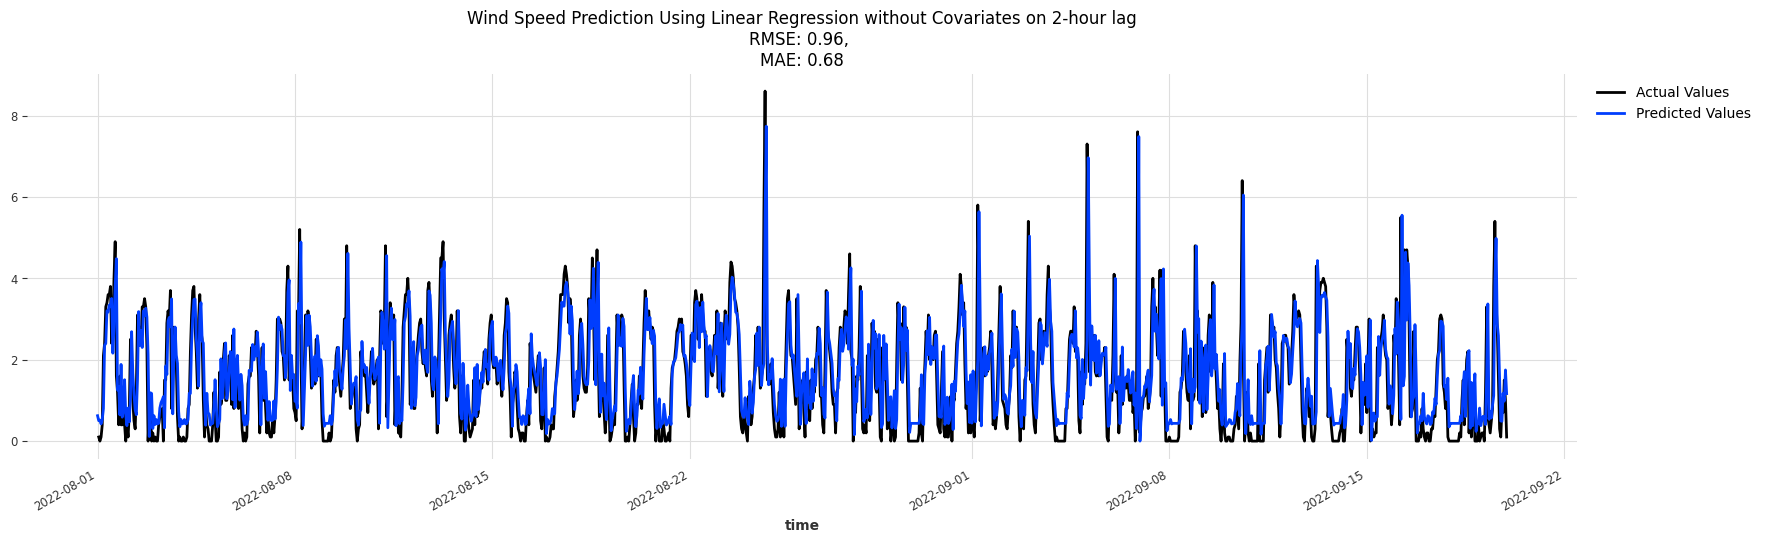

In [ ]:
# Predicting wind speed without Covariates on 2-hour lag using LR model
lr_ws_nocov_model, model_results = train_eval_model(lr_nocov_model, ts_WS, train_WS_ts, pred_after,
                                                    model_name = "Linear Regression without Covariates on 2-hour lag", target_desc = "Wind Speed",
                                                    chart_title = "Wind Speed Prediction Using Linear Regression without Covariates on 2-hour lag",
                                                    clip_min = 0, summary_df = model_results)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


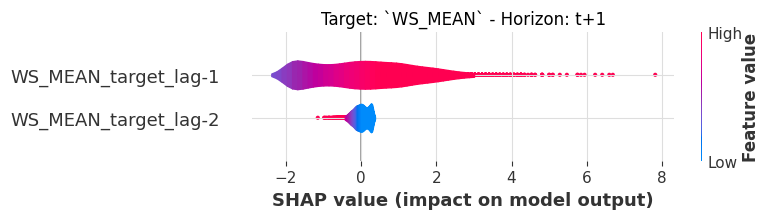

In [ ]:
explainer = ShapExplainer(lr_ws_nocov_model)
explainer.summary_plot(plot_type='violin')

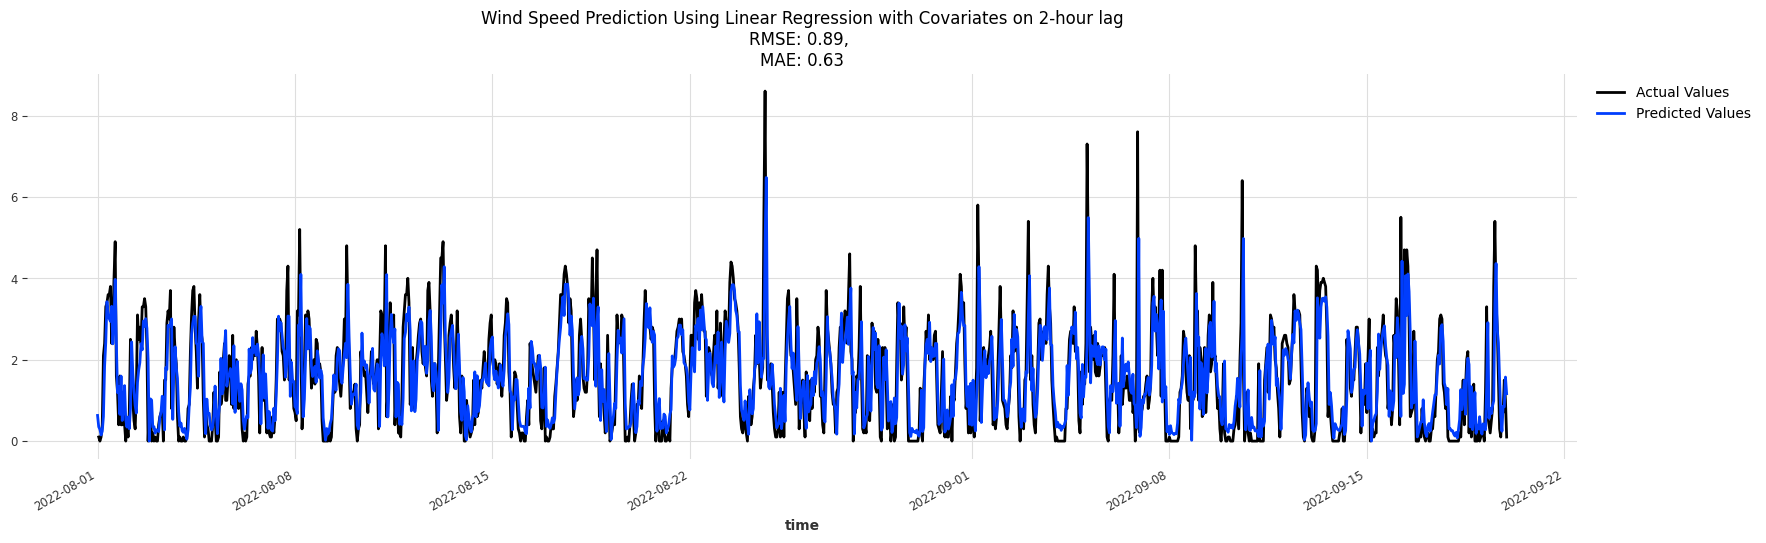

In [ ]:
# Predicting wind speed with Covariates on 2-hour lag using LR model
lr_ws_cov_model, model_results = train_eval_model(lr_cov_model, ts_WS, train_WS_ts, pred_after, past_cov=ts_cov_ws,
                                                  model_name = "Linear Regression with Covariates on 2-hour lag", target_desc = "Wind Speed",
                                                  chart_title = "Wind Speed Prediction Using Linear Regression with Covariates on 2-hour lag",
                                                  clip_min = 0, summary_df = model_results)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


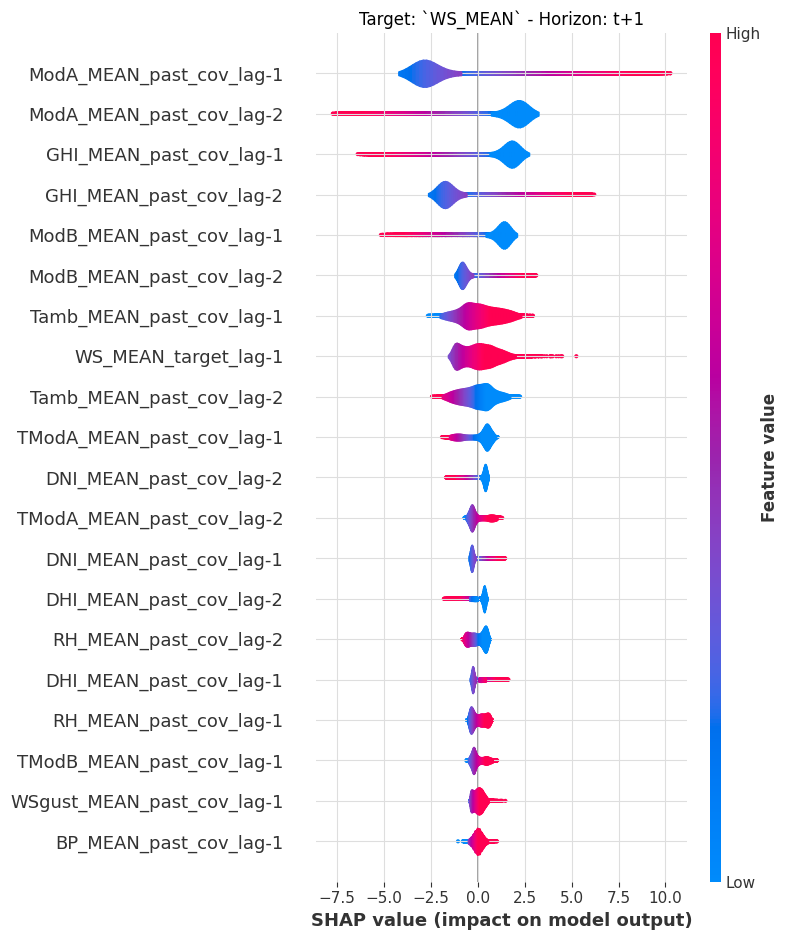

In [ ]:
explainer = ShapExplainer(lr_ws_cov_model)
explainer.summary_plot(plot_type='violin')

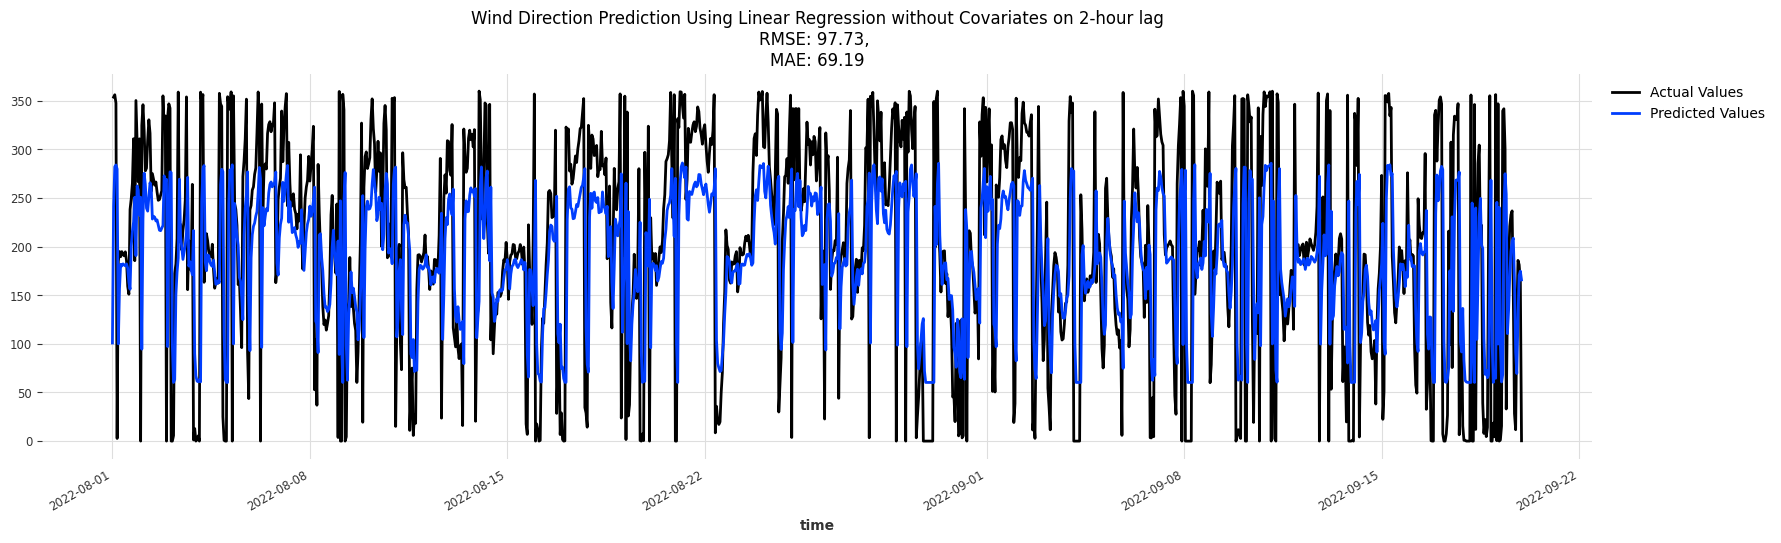

In [ ]:
# Predicting Wind Direction without Covariates on 2-hour lag using LR model
lr_wd_nocov_model, model_results = train_eval_model(lr_nocov_model, ts_WD, train_WD_ts, pred_after,
                                                    model_name = "Linear Regression without Covariates on 2-hour lag", target_desc = "Wind Direction",
                                                    chart_title = "Wind Direction Prediction Using Linear Regression without Covariates on 2-hour lag",
                                                    clip_min = 0, clip_max = 360, summary_df = model_results)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


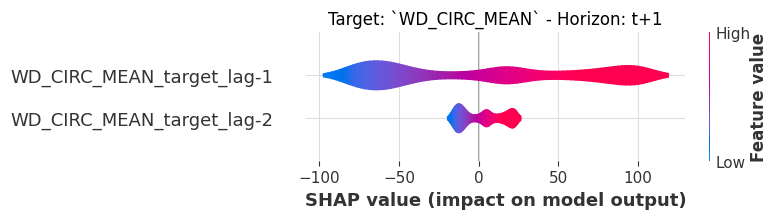

In [ ]:
explainer = ShapExplainer(lr_wd_nocov_model)
explainer.summary_plot(plot_type='violin')

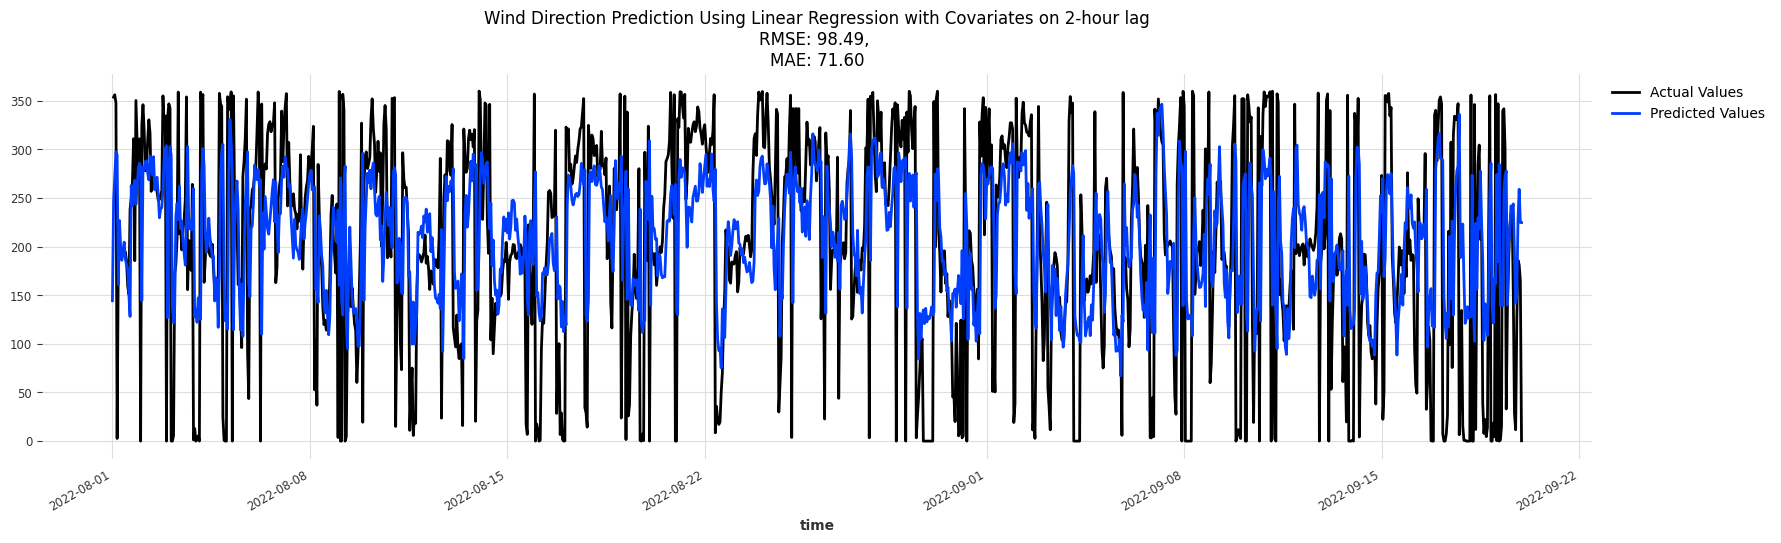

In [ ]:
# Predicting Wind Direction with Covariates on 2-hour lag using LR model
lr_wd_cov_model, model_results = train_eval_model(lr_cov_model, ts_WD, train_WD_ts, pred_after, past_cov=ts_cov_wd,
                                                  model_name = "Linear Regression with Covariates on 2-hour lag", target_desc = "Wind Direction",
                                                  chart_title = "Wind Direction Prediction Using Linear Regression with Covariates on 2-hour lag",
                                                  clip_min = 0, clip_max = 360, summary_df = model_results)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


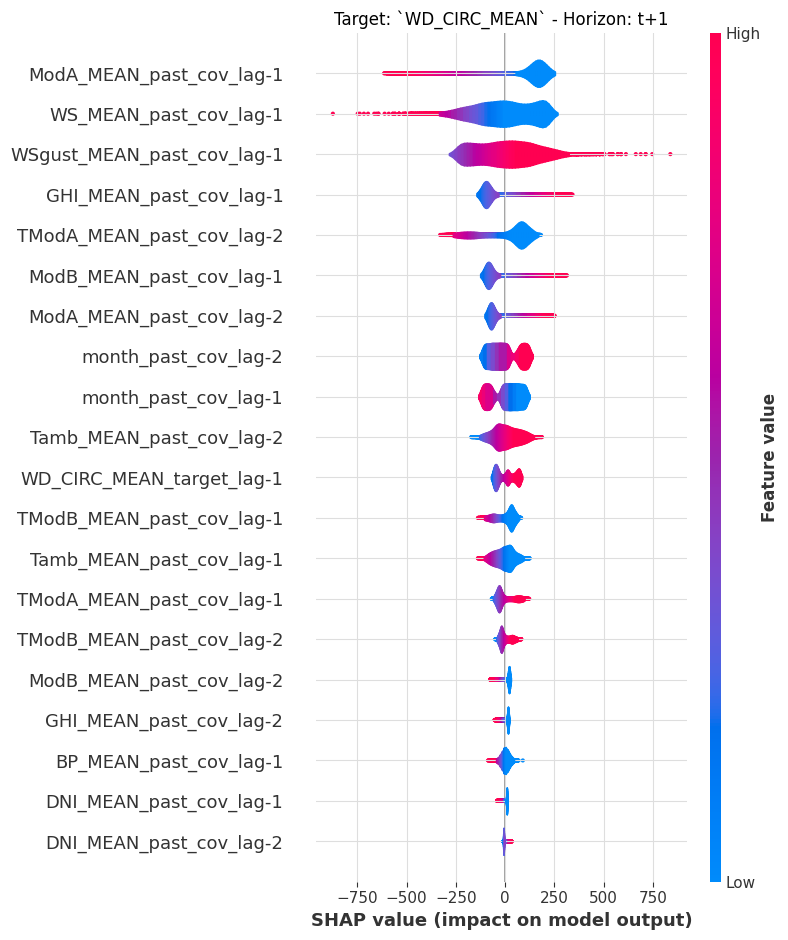

In [ ]:
explainer = ShapExplainer(lr_wd_cov_model)
explainer.summary_plot(plot_type='violin')

### Using Random Forest Model

In [ ]:
# Define the Random Forest Regression Model without Covariates on 2-hour lag
rf_nocov_model = RandomForest(lags=lag)

# Define the Random Forest Regression for covariates inclusion
rf_cov_model = RandomForest(lags=lag, lags_past_covariates=lag)

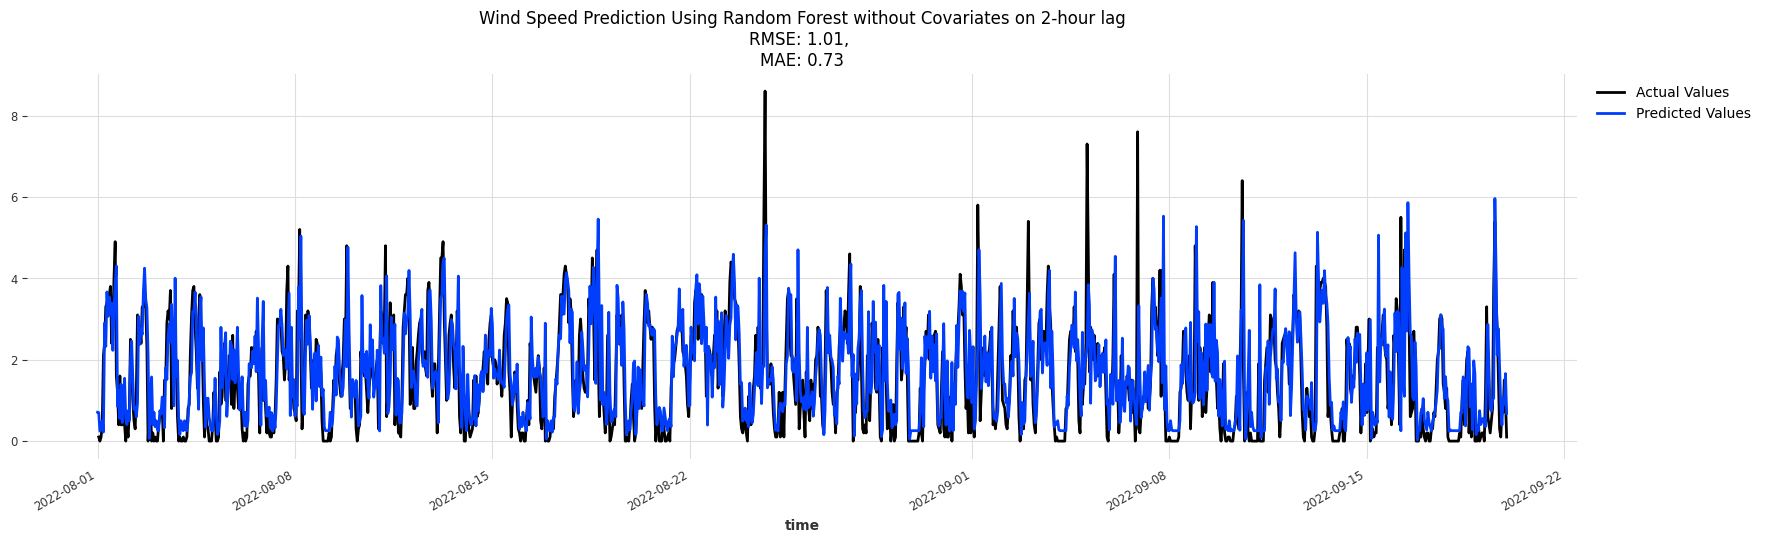

In [ ]:
# Predicting Wind Speed without Covariates on 2-hour lag using rf model
rf_ws_nocov_model, model_results = train_eval_model(rf_nocov_model, ts_WS, train_WS_ts, pred_after,
                                                               model_name = "Random Forest Regression without Covariates on 2-hour lag", target_desc = "Wind Speed",
                                                               chart_title = "Wind Speed Prediction Using Random Forest without Covariates on 2-hour lag",
                                                               clip_min = 0, summary_df = model_results)

In [ ]:
explainer = ShapExplainer(rf_ws_nocov_model, shap_method='tree')
explainer.summary_plot(plot_type='violin')

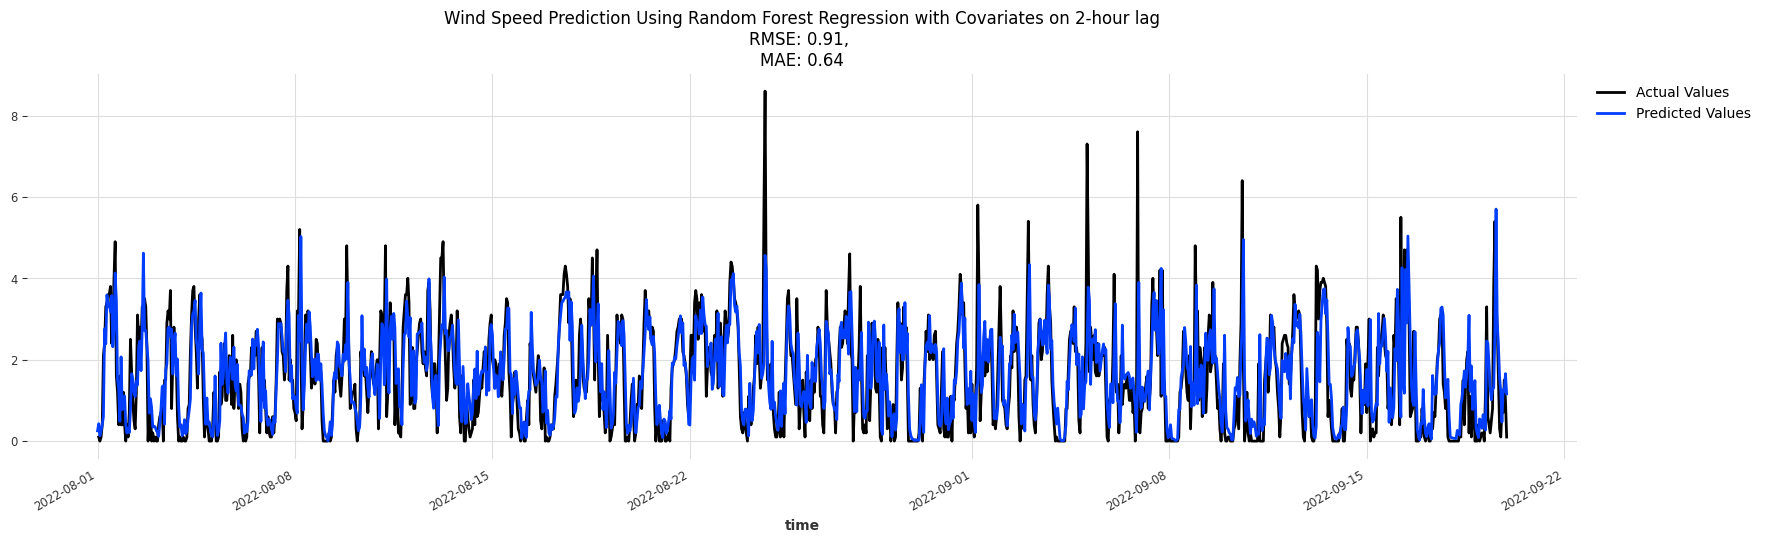

In [ ]:
# Predicting Wind Speed with Covariates on 2-hour lag using rf model
rf_ws_cov_model, model_results = train_eval_model(rf_cov_model, ts_WS, train_WS_ts, pred_after, past_cov=ts_cov_ws, 
                                                  model_name = "Random Forest Regression with Covariates on 2-hour lag", target_desc = "Wind Speed",
                                                  chart_title = "Wind Speed Prediction Using Random Forest Regression with Covariates on 2-hour lag",
                                                  clip_min = 0, summary_df = model_results)

In [ ]:
explainer = ShapExplainer(rf_ws_cov_model, shap_method='tree')
explainer.summary_plot(plot_type='violin')

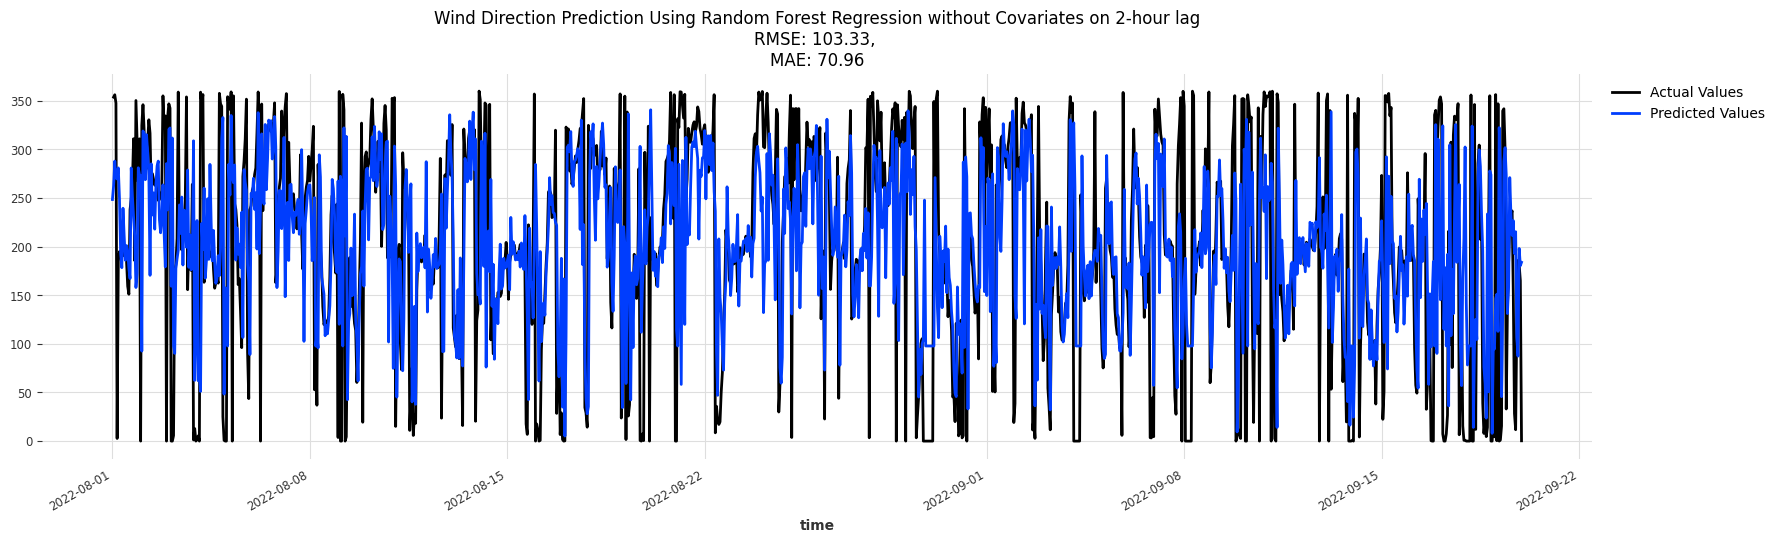

In [ ]:
# Predicting Wind Direction without Covariates on 2-hour lag using rf model
rf_wd_nocov_model, model_results = train_eval_model(rf_nocov_model, ts_WD, train_WD_ts, pred_after,
                                                               model_name = "Random Forest Regression without Covariates on 2-hour lag", target_desc = "Wind Direction",
                                                               chart_title = "Wind Direction Prediction Using Random Forest Regression without Covariates on 2-hour lag",
                                                               clip_min = 0, clip_max = 360, summary_df = model_results)

In [ ]:
explainer = ShapExplainer(rf_wd_nocov_model, shap_method='tree')
explainer.summary_plot(plot_type='violin')

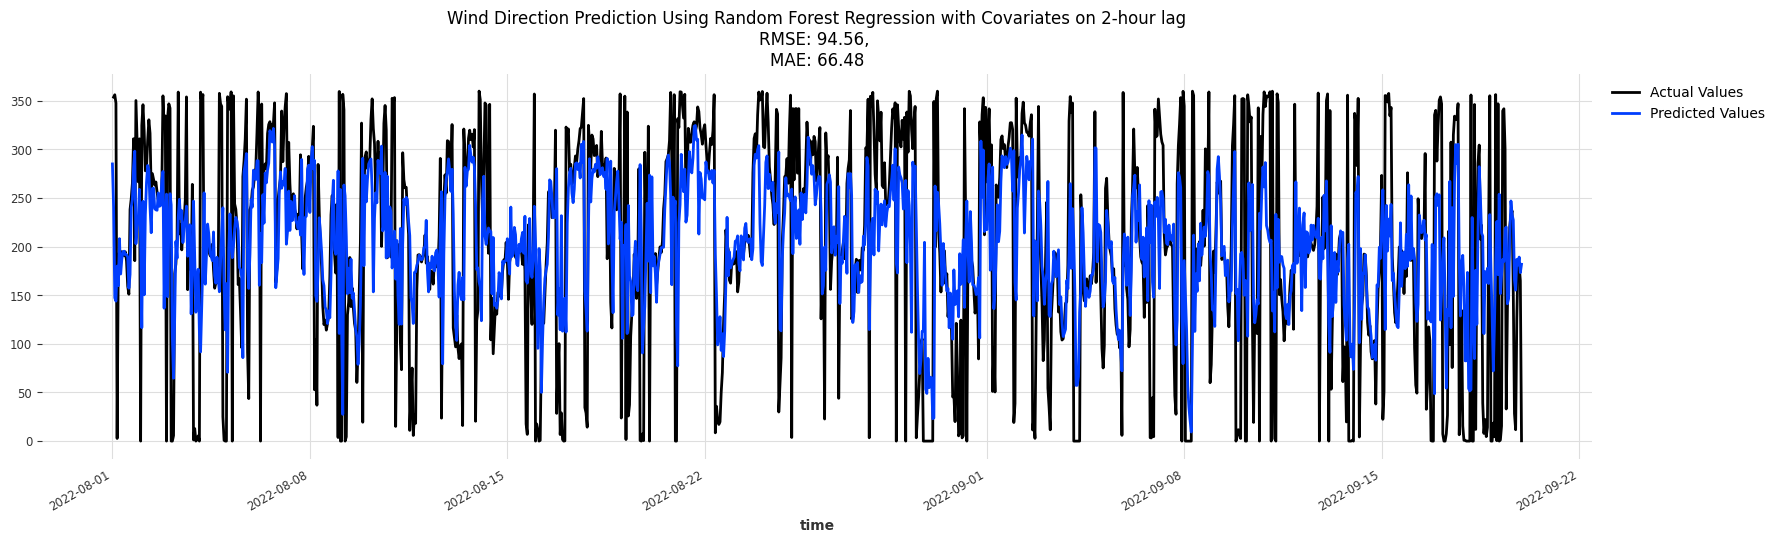

In [ ]:
# Predicting Wind Direction with Covariates on 2-hour lag using rf model
rf_wd_cov_model, model_results = train_eval_model(rf_cov_model, ts_WD, train_WD_ts, pred_after, past_cov=ts_cov_wd, 
                                                  model_name = "Random Forest Regression with Covariates on 2-hour lag", target_desc = "Wind Direction",
                                                  chart_title = "Wind Direction Prediction Using Random Forest Regression with Covariates on 2-hour lag",
                                                  clip_min = 0, clip_max = 360, summary_df = model_results)

In [ ]:
explainer = ShapExplainer(rf_wd_cov_model, shap_method='tree')
explainer.summary_plot(plot_type='violin')

### Using CatBoost Model

In [ ]:
# Define the CatBoost Model without Covariates on 2-hour lag
cb_nocov_model = CatBoostModel(lags=lag)

# Define the CatBoost for covariates inclusion
cb_cov_model = CatBoostModel(lags=lag, lags_past_covariates=lag)

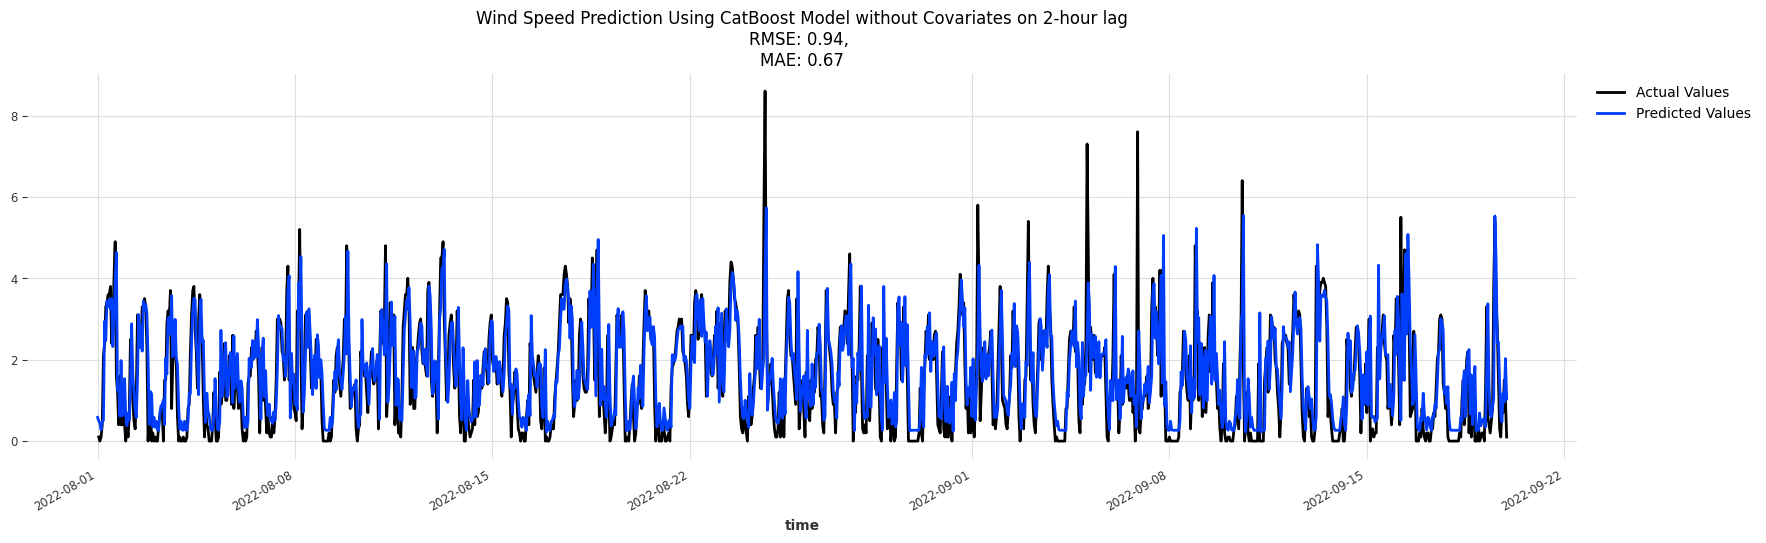

In [ ]:
# Predicting Wind Speed without Covariates on 2-hour lag using cb model
cb_ws_nocov_model, model_results = train_eval_model(cb_nocov_model, ts_WS, train_WS_ts, pred_after,
                                                    model_name = "CatBoost Model without Covariates on 2-hour lag", target_desc = "Wind Speed",
                                                    chart_title = "Wind Speed Prediction Using CatBoost Model without Covariates on 2-hour lag",
                                                    clip_min = 0, summary_df = model_results)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


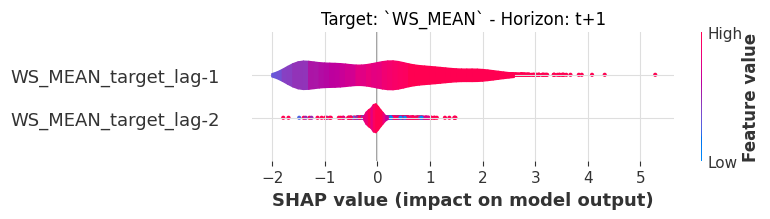

In [ ]:
explainer = ShapExplainer(cb_ws_nocov_model)
explainer.summary_plot(plot_type='violin')

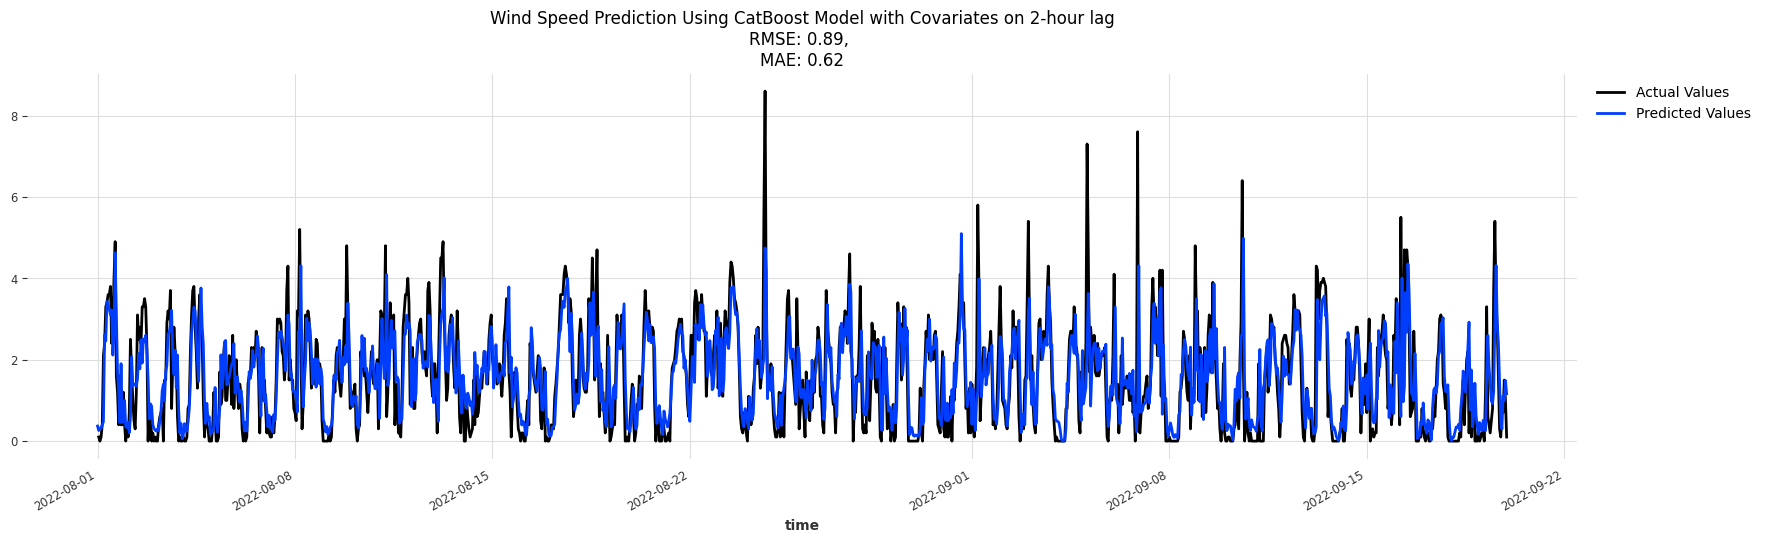

In [ ]:
# Predicting Wind Speed with Covariates on 2-hour lag using cb model
cb_ws_cov_model, model_results = train_eval_model(cb_cov_model, ts_WS, train_WS_ts, pred_after, past_cov=ts_cov_ws,
                                                  model_name = "CatBoost Model with Covariates on 2-hour lag", target_desc = "Wind Speed",
                                                  chart_title = "Wind Speed Prediction Using CatBoost Model with Covariates on 2-hour lag",
                                                  clip_min = 0, summary_df = model_results)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


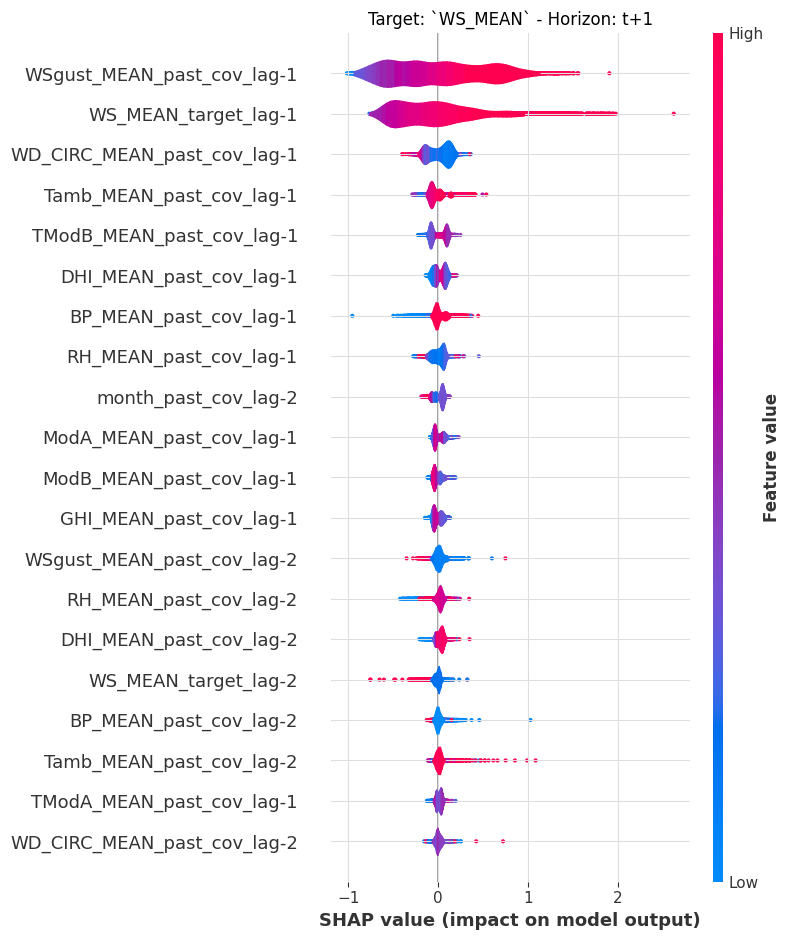

In [ ]:
explainer = ShapExplainer(cb_ws_cov_model)
explainer.summary_plot(plot_type='violin')

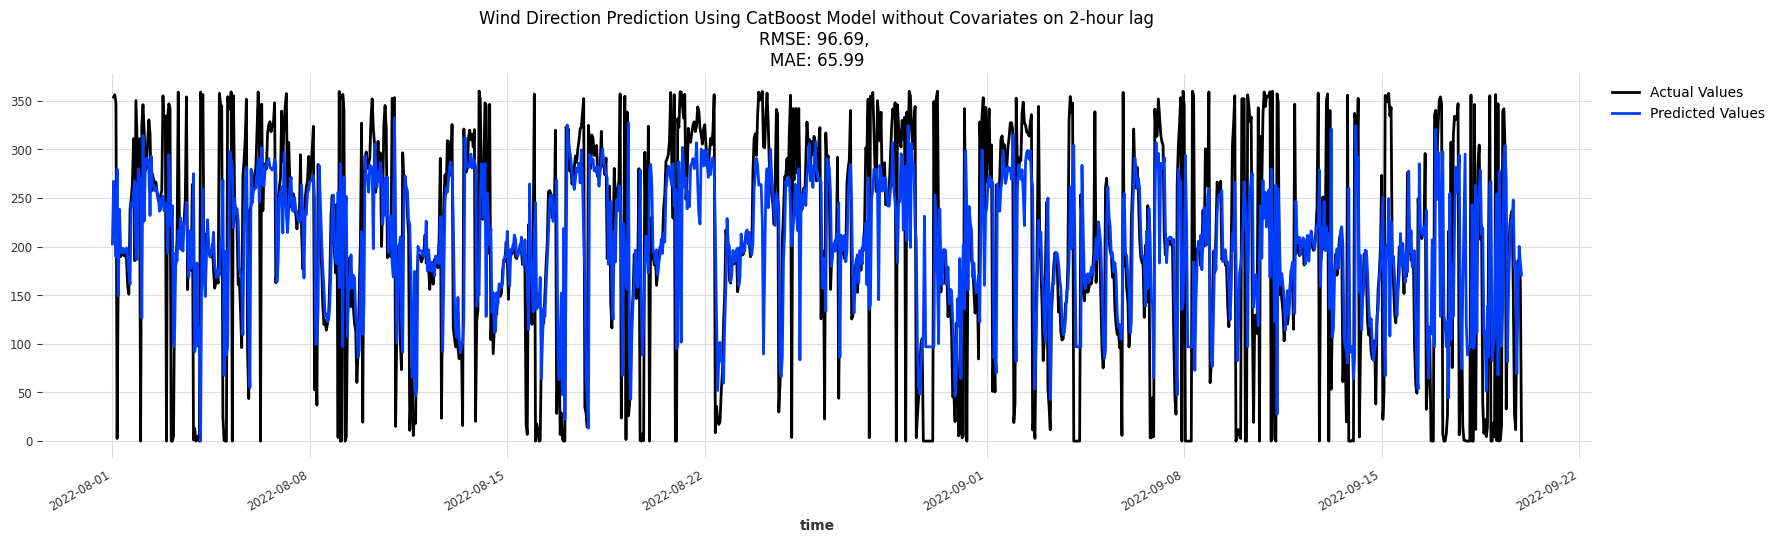

In [ ]:
# Predicting Wind Direction without Covariates on 2-hour lag using cb model
cb_wd_nocov_model, model_results = train_eval_model(cb_nocov_model, ts_WD, train_WD_ts, pred_after,
                                                    model_name = "CatBoost Model without Covariates on 2-hour lag", target_desc = "Wind Direction",
                                                    chart_title = "Wind Direction Prediction Using CatBoost Model without Covariates on 2-hour lag",
                                                    clip_min = 0, clip_max = 360, summary_df = model_results)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


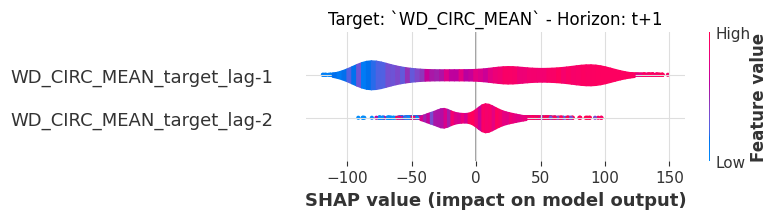

In [ ]:
explainer = ShapExplainer(cb_wd_nocov_model)
explainer.summary_plot(plot_type='violin')

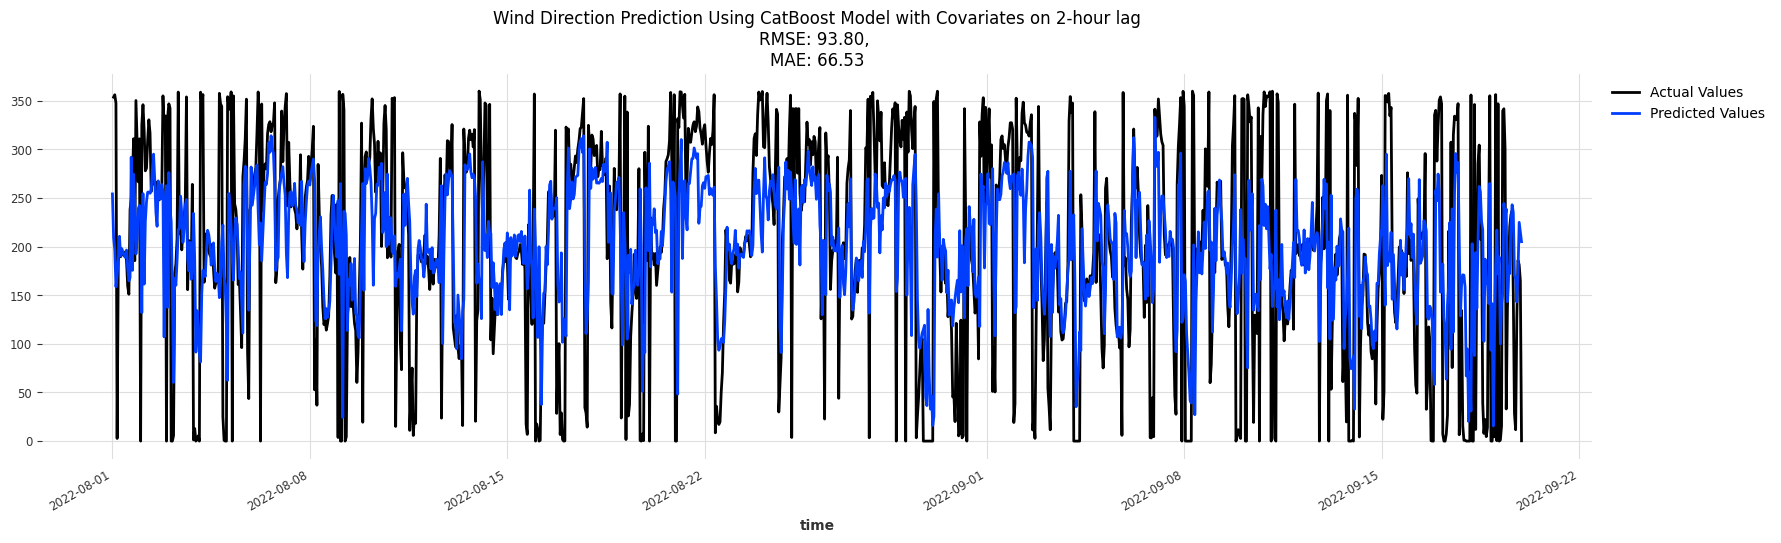

In [ ]:
# Predicting Wind Direction with Covariates on 2-hour lag using cb model
cb_wd_cov_model, model_results = train_eval_model(cb_cov_model, ts_WD, train_WD_ts, pred_after, past_cov=ts_cov_wd,
                                                  model_name = "CatBoost Model with Covariates on 2-hour lag", target_desc = "Wind Direction",
                                                  chart_title = "Wind Direction Prediction Using CatBoost Model with Covariates on 2-hour lag",
                                                  clip_min = 0, clip_max = 360, summary_df = model_results)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


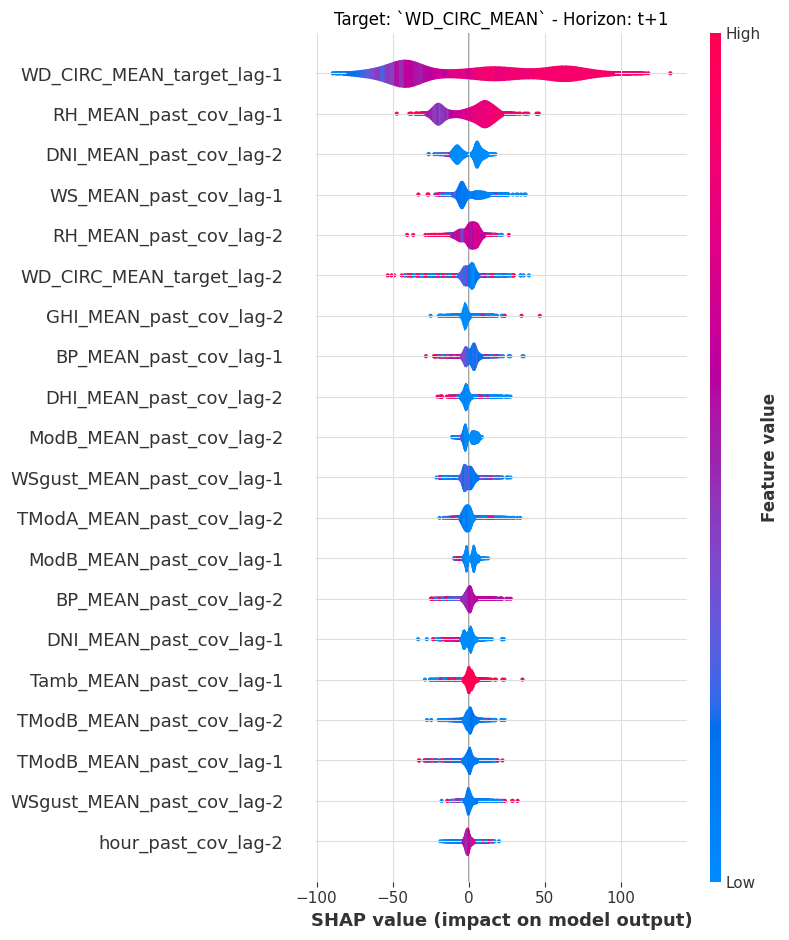

In [ ]:
explainer = ShapExplainer(cb_wd_cov_model)
explainer.summary_plot(plot_type='violin')

### Using LightGBM Model

In [ ]:
# Define the LightGBM Model without Covariates on 2-hour lag
lgbm_nocov_model = LightGBMModel(lags=lag)

# Define the LightGBM for covariates inclusion
lgbm_cov_model = LightGBMModel(lags=lag, lags_past_covariates=lag)

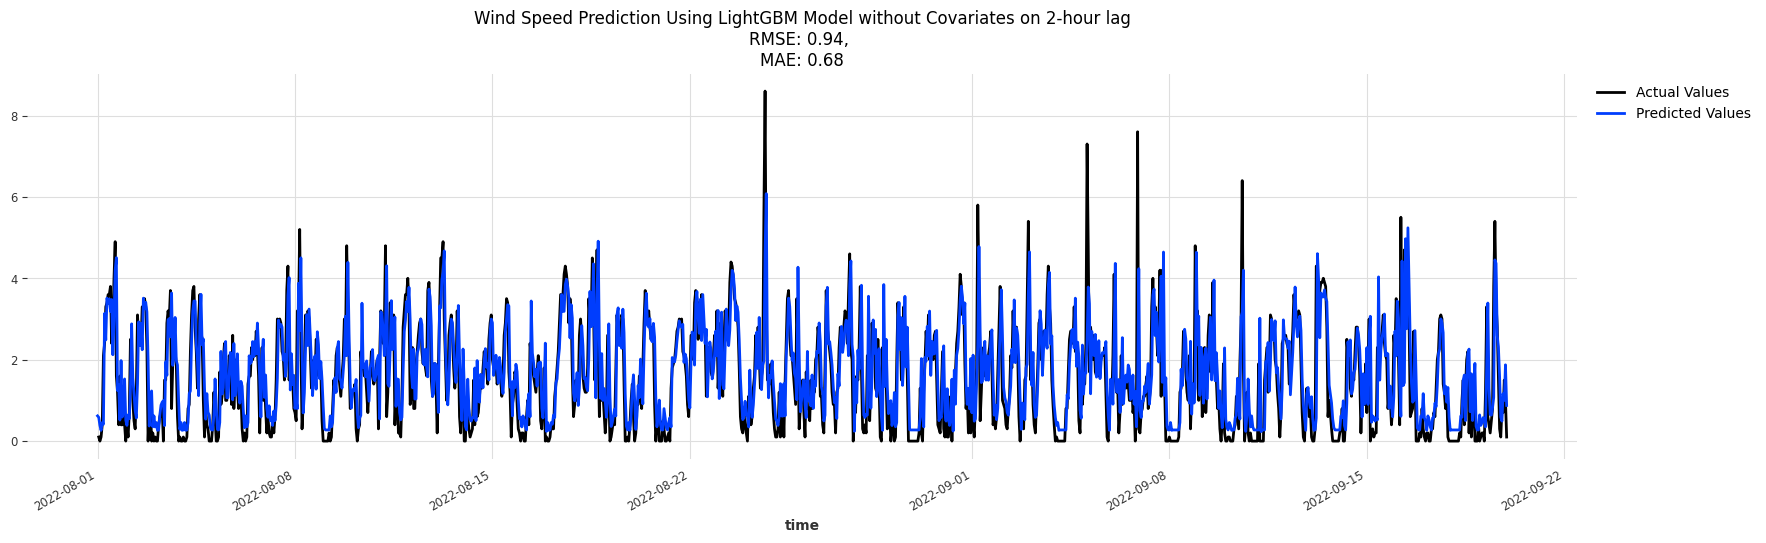

In [ ]:
# Predicting Wind Speed without Covariates on 2-hour lag using lgbm model
lgbm_ws_nocov_model, model_results = train_eval_model(lgbm_nocov_model, ts_WS, train_WS_ts, pred_after,
                                                      model_name = "LightGBM Model without Covariates on 2-hour lag", target_desc = "Wind Speed",
                                                      chart_title = "Wind Speed Prediction Using LightGBM Model without Covariates on 2-hour lag",
                                                      clip_min = 0, summary_df = model_results)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


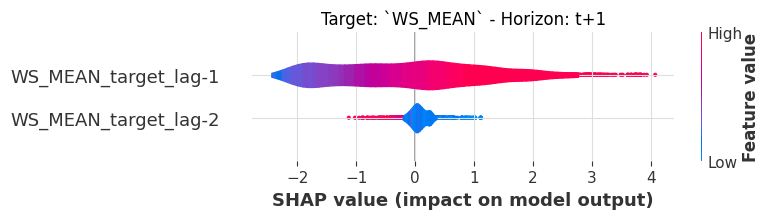

In [ ]:
explainer = ShapExplainer(lgbm_ws_nocov_model)
explainer.summary_plot(plot_type='violin')

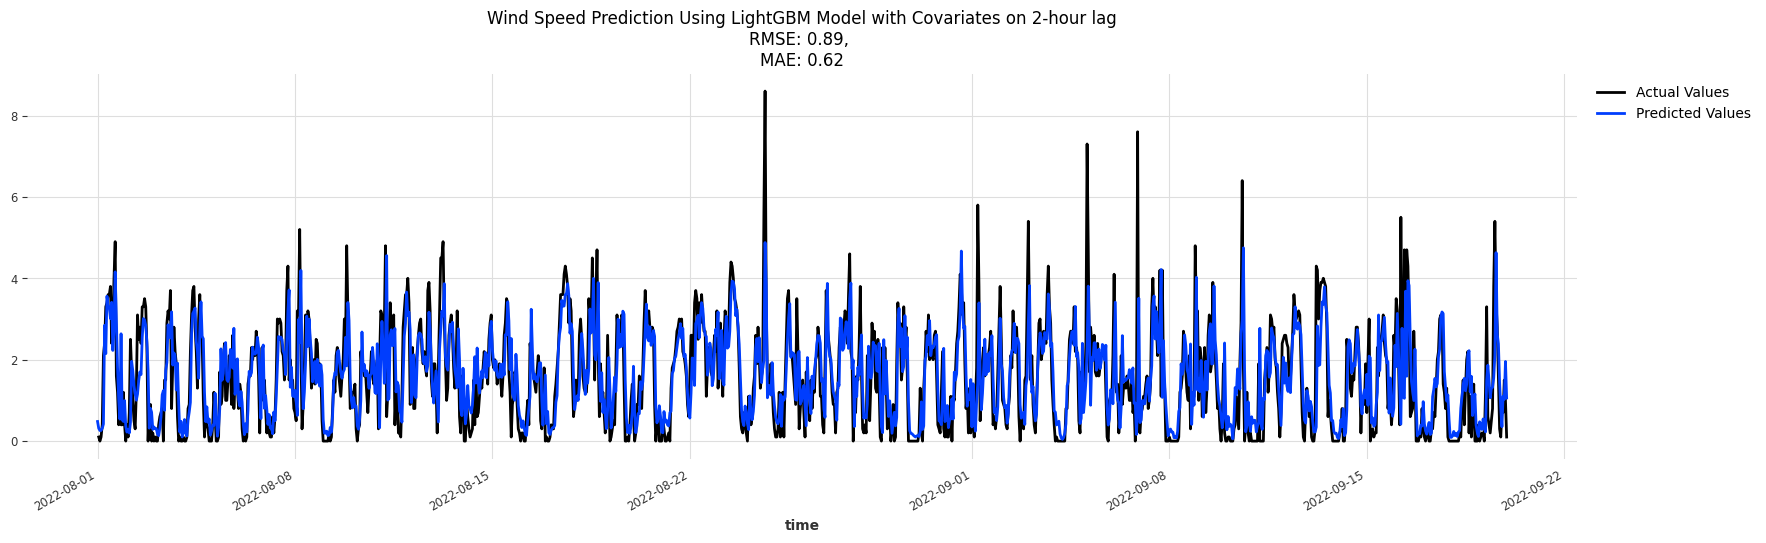

In [ ]:
# Predicting Wind Speed with Covariates on 2-hour lag using lgbm model
lgbm_ws_cov_model, model_results = train_eval_model(lgbm_cov_model, ts_WS, train_WS_ts, pred_after, past_cov=ts_cov_ws,
                                                    model_name = "LightGBM Model with Covariates on 2-hour lag", target_desc = "Wind Speed",
                                                    chart_title = "Wind Speed Prediction Using LightGBM Model with Covariates on 2-hour lag",
                                                    clip_min = 0, summary_df = model_results)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


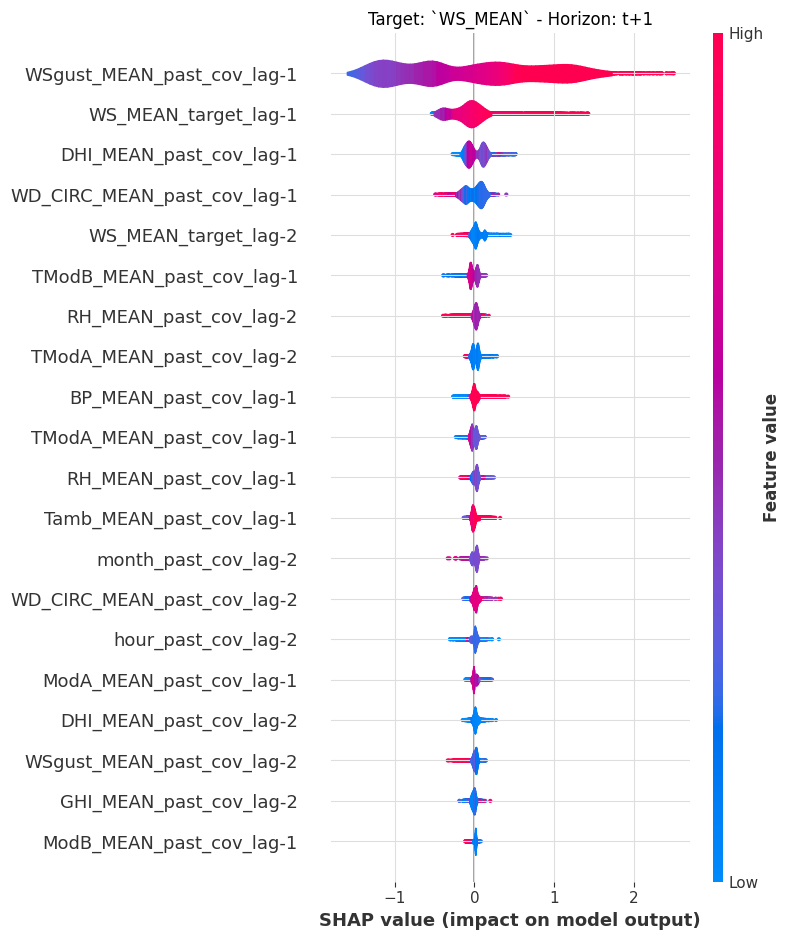

In [ ]:
explainer = ShapExplainer(lgbm_ws_cov_model)
explainer.summary_plot(plot_type='violin')

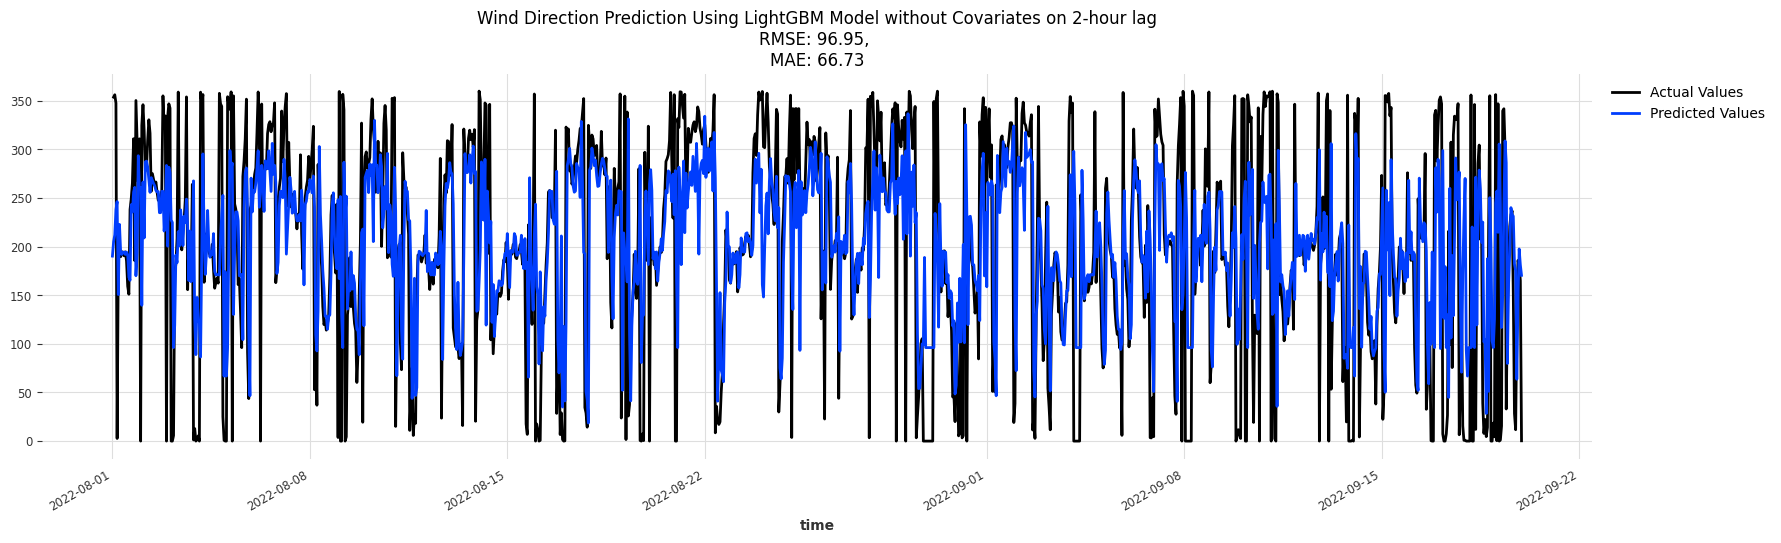

In [ ]:
# Predicting Wind Direction without Covariates on 2-hour lag using lgbm model
lgbm_wd_nocov_model, model_results = train_eval_model(lgbm_nocov_model, ts_WD, train_WD_ts, pred_after,
                                                               model_name = "LightGBM Model without Covariates on 2-hour lag", target_desc = "Wind Direction",
                                                               chart_title = "Wind Direction Prediction Using LightGBM Model without Covariates on 2-hour lag",
                                                               clip_min = 0, clip_max = 360, summary_df = model_results)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


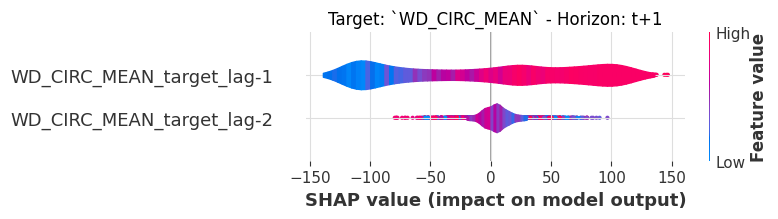

In [ ]:
explainer = ShapExplainer(lgbm_wd_nocov_model)
explainer.summary_plot(plot_type='violin')

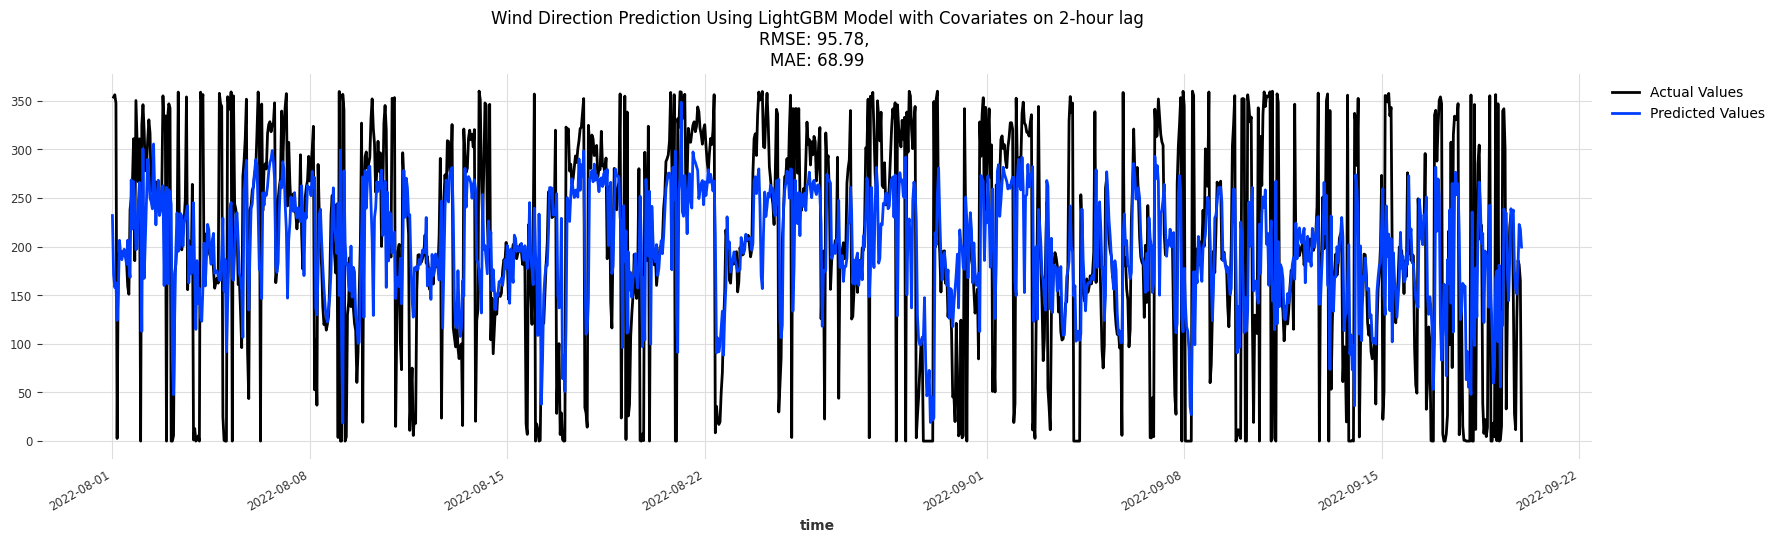

In [ ]:
# Predicting Wind Direction with Covariates on 2-hour lag using lgbm model
lgbm_wd_cov_model, model_results = train_eval_model(lgbm_cov_model, ts_WD, train_WD_ts, pred_after, past_cov=ts_cov_wd,
                                                    model_name = "LightGBM Model with Covariates on 2-hour lag", target_desc = "Wind Direction",
                                                    chart_title = "Wind Direction Prediction Using LightGBM Model with Covariates on 2-hour lag",
                                                    clip_min = 0, clip_max = 360, summary_df = model_results)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


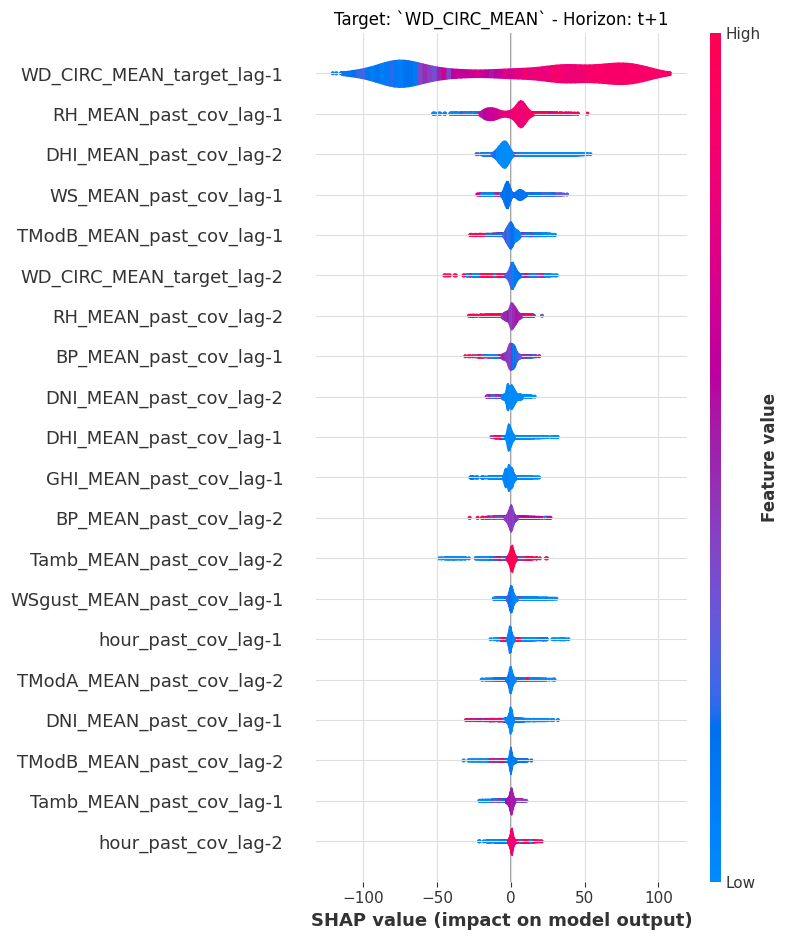

In [ ]:
explainer = ShapExplainer(lgbm_wd_cov_model)
explainer.summary_plot(plot_type='violin')

### Using XGBoost Model

In [ ]:
# Define the LightGBM Model without Covariates on 2-hour lag
xgbm_nocov_model = XGBModel(lags=lag)

# Define the LightGBM for covariates inclusion
xgbm_cov_model = XGBModel(lags=lag, lags_past_covariates=lag)

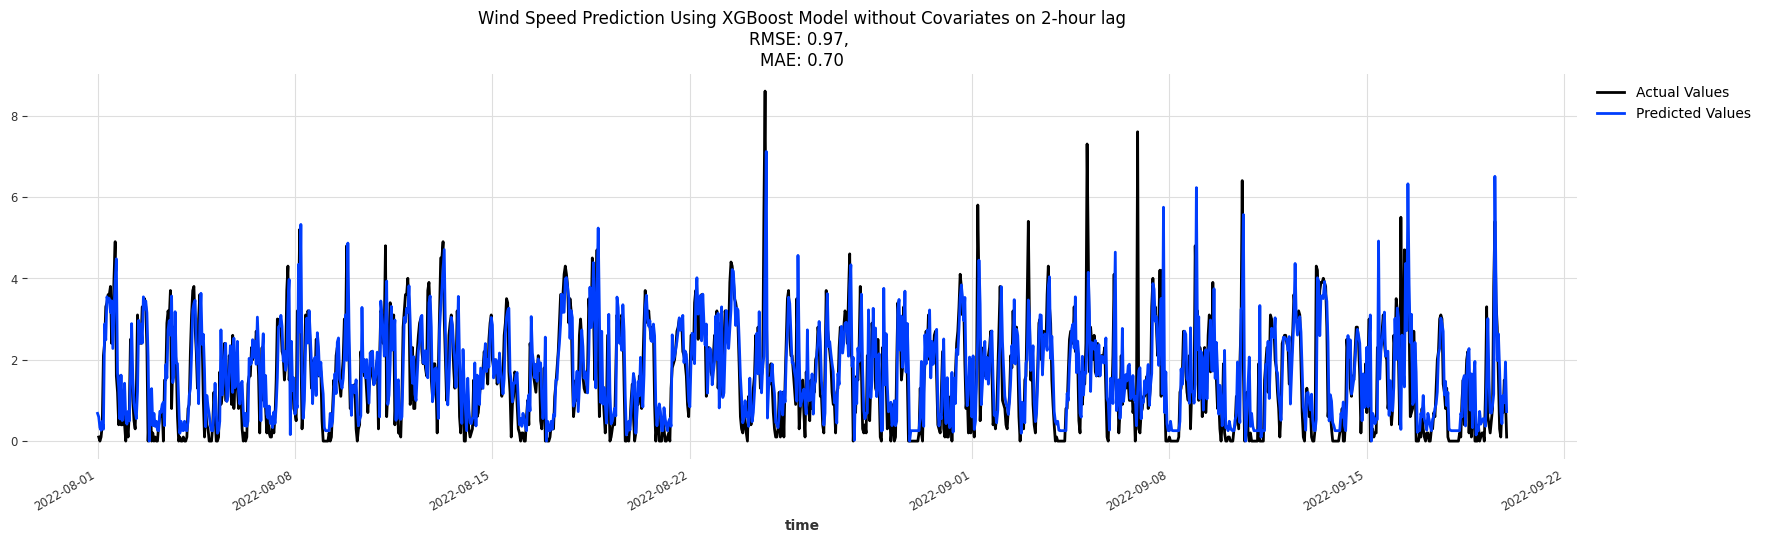

In [ ]:
# Predicting Wind Speed without Covariates on 2-hour lag using xgbm model
xgbm_ws_nocov_model, model_results = train_eval_model(xgbm_nocov_model, ts_WS, train_WS_ts, pred_after,
                                                      model_name = "XGBoost Model without Covariates on 2-hour lag", target_desc = "Wind Speed",
                                                      chart_title = "Wind Speed Prediction Using XGBoost Model without Covariates on 2-hour lag",
                                                      clip_min = 0, summary_df = model_results)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


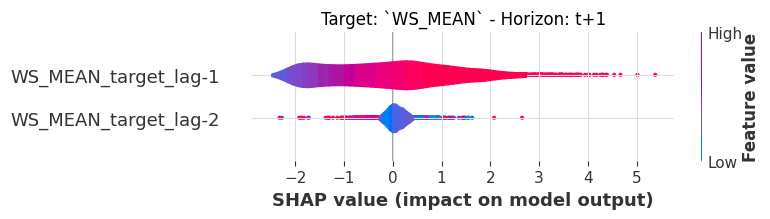

In [ ]:
explainer = ShapExplainer(xgbm_ws_nocov_model)
explainer.summary_plot(plot_type='violin')

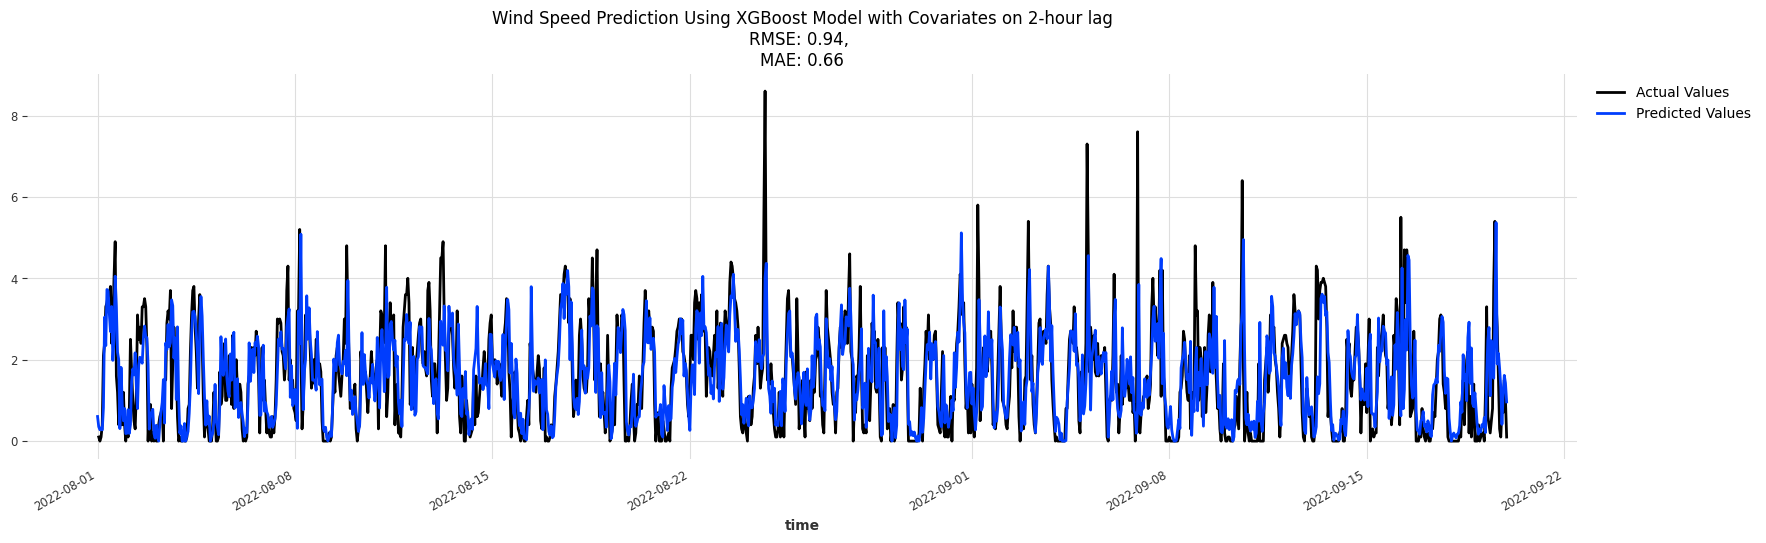

In [ ]:
# Predicting Wind Speed with Covariates on 2-hour lag using xgbm model
xgbm_ws_cov_model, model_results = train_eval_model(xgbm_cov_model, ts_WS, train_WS_ts, pred_after, past_cov=ts_cov_ws,
                                                    model_name = "XGBoost Model with Covariates on 2-hour lag", target_desc = "Wind Speed",
                                                    chart_title = "Wind Speed Prediction Using XGBoost Model with Covariates on 2-hour lag",
                                                    clip_min = 0, summary_df = model_results)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


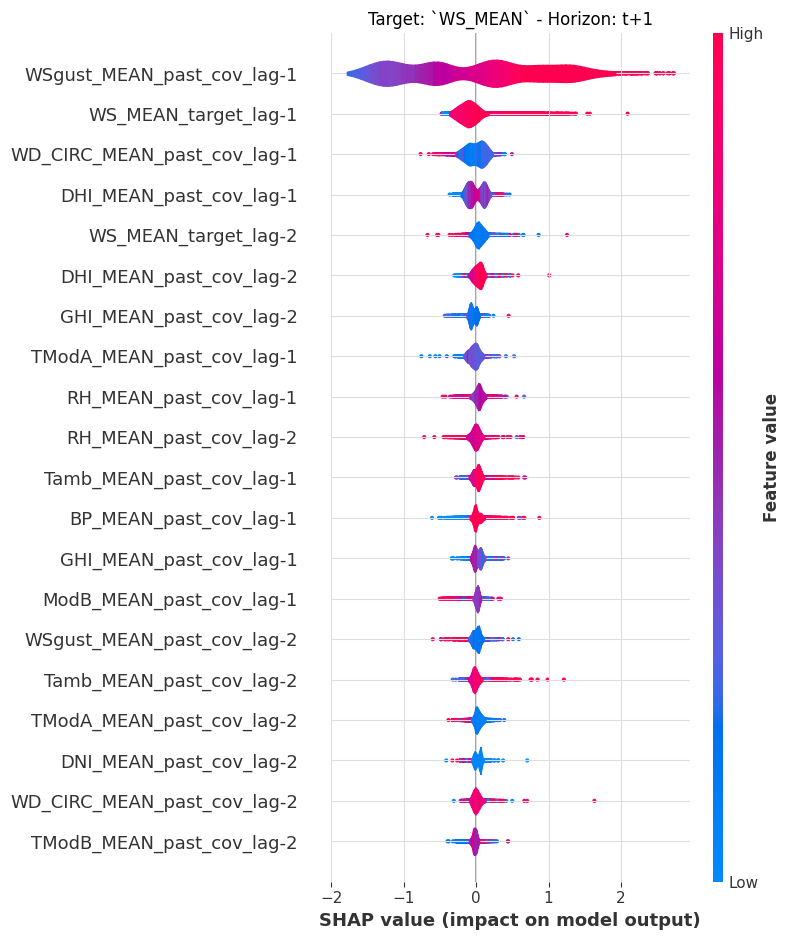

In [ ]:
explainer = ShapExplainer(xgbm_ws_cov_model)
explainer.summary_plot(plot_type='violin')

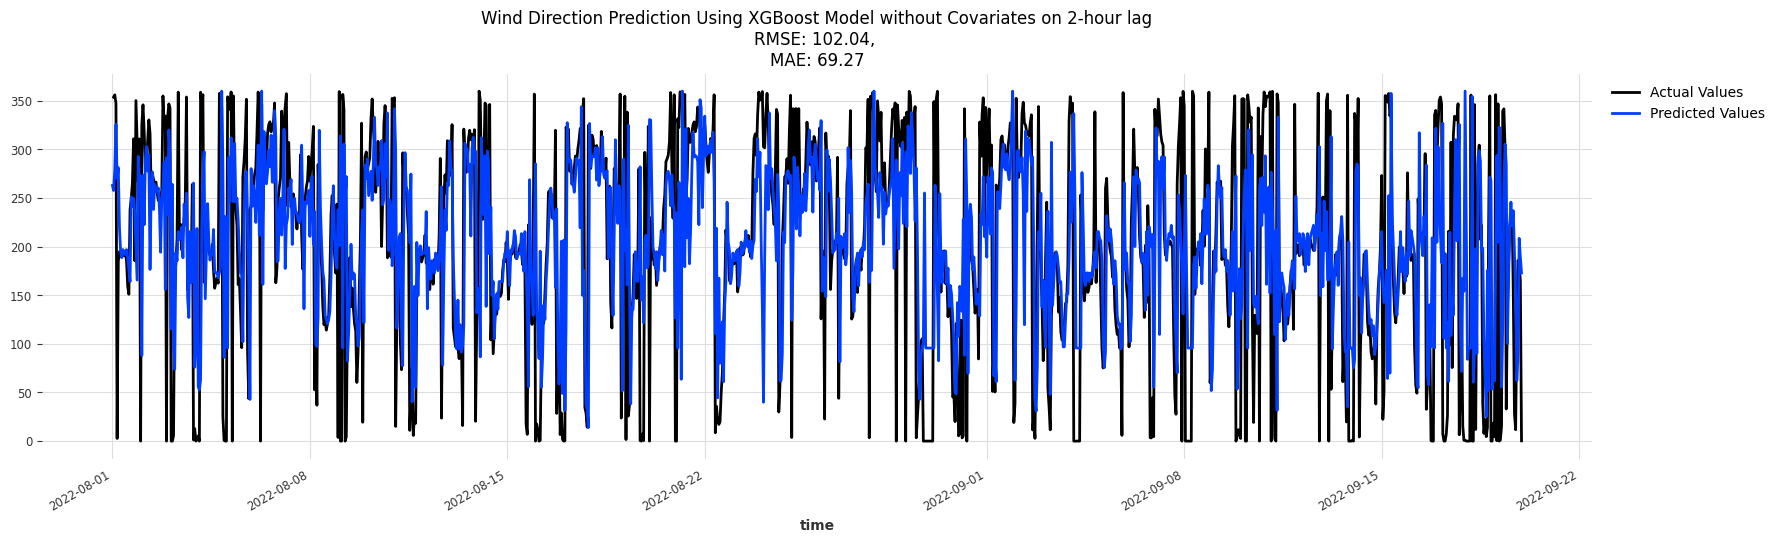

In [ ]:
# Predicting Wind Direction without Covariates on 2-hour lag using xgbm model
xgbm_wd_nocov_model, model_results = train_eval_model(xgbm_nocov_model, ts_WD, train_WD_ts, pred_after,
                                                               model_name = "XGBoost Model without Covariates on 2-hour lag", target_desc = "Wind Direction",
                                                               chart_title = "Wind Direction Prediction Using XGBoost Model without Covariates on 2-hour lag",
                                                               clip_min = 0, clip_max = 360, summary_df = model_results)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


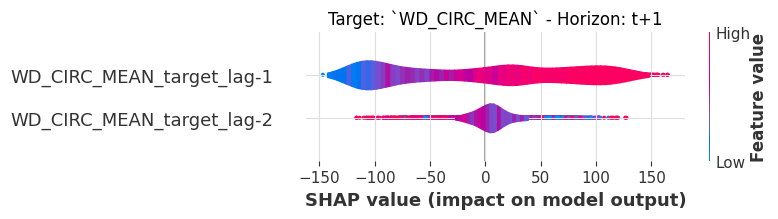

In [ ]:
explainer = ShapExplainer(xgbm_wd_nocov_model)
explainer.summary_plot(plot_type='violin')

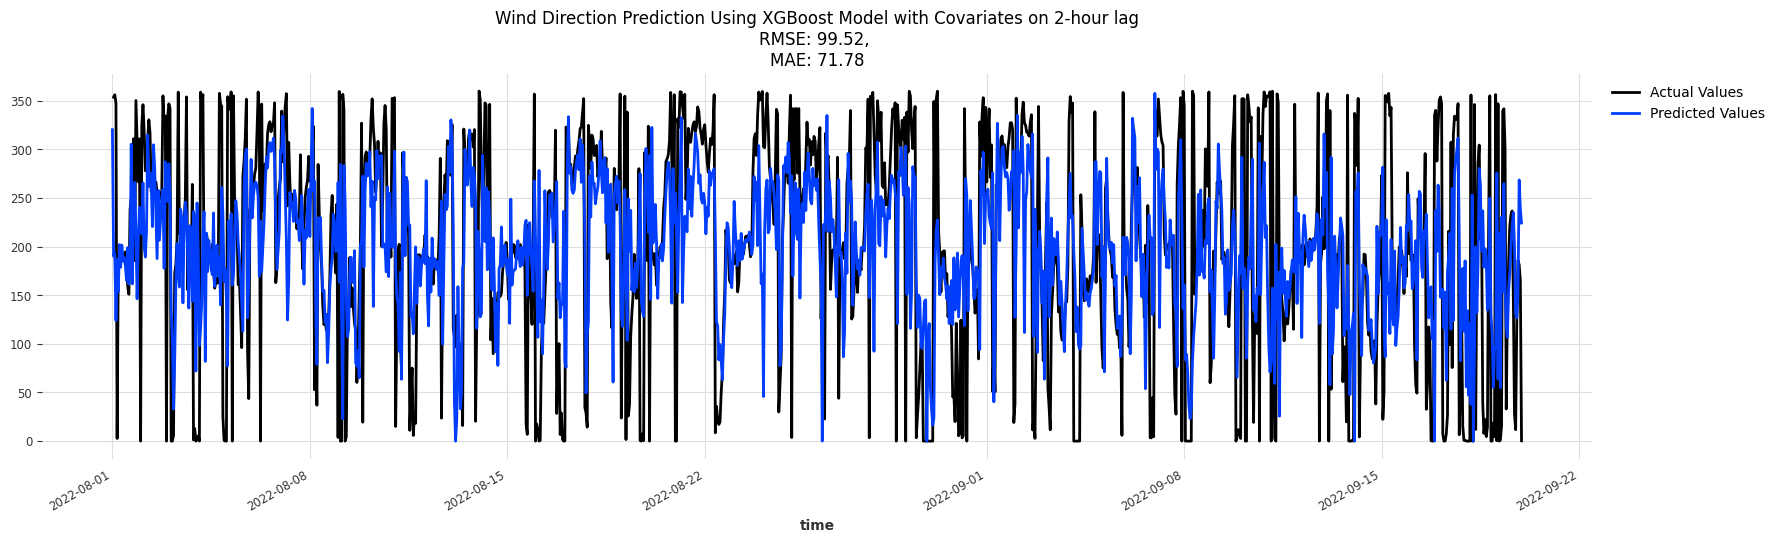

In [ ]:
# Predicting Wind Direction with Covariates on 2-hour lag using xgbm model
xgbm_wd_cov_model, model_results = train_eval_model(xgbm_cov_model, ts_WD, train_WD_ts, pred_after, past_cov=ts_cov_wd,
                                                    model_name = "XGBoost Model with Covariates on 2-hour lag", target_desc = "Wind Direction",
                                                    chart_title = "Wind Direction Prediction Using XGBoost Model with Covariates on 2-hour lag",
                                                    clip_min = 0, clip_max = 360, summary_df = model_results)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


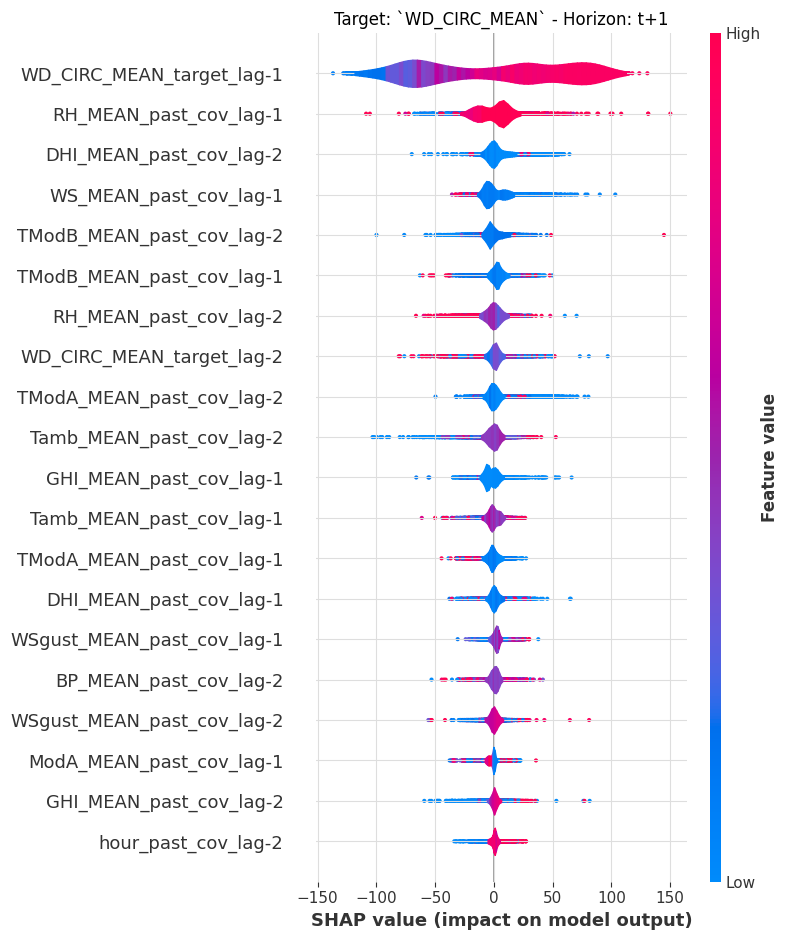

In [ ]:
explainer = ShapExplainer(xgbm_wd_cov_model)
explainer.summary_plot(plot_type='violin')

In [ ]:
model_results

Model Name          Target  \
0   Linear Regression without Covariates on 2-hour...      Wind Speed   
1     Linear Regression with Covariates on 2-hour lag      Wind Speed   
2   Linear Regression without Covariates on 2-hour...  Wind Direction   
3     Linear Regression with Covariates on 2-hour lag  Wind Direction   
4   Random Forest Regression without Covariates on...      Wind Speed   
5   Random Forest Regression with Covariates on 2-...      Wind Speed   
6   Random Forest Regression without Covariates on...  Wind Direction   
7   Random Forest Regression with Covariates on 2-...  Wind Direction   
8     CatBoost Model without Covariates on 2-hour lag      Wind Speed   
9        CatBoost Model with Covariates on 2-hour lag      Wind Speed   
10    CatBoost Model without Covariates on 2-hour lag  Wind Direction   
11       CatBoost Model with Covariates on 2-hour lag  Wind Direction   
12    LightGBM Model without Covariates on 2-hour lag      Wind Speed   
13       LightGBM Model with Covariates on 2-hour lag      Wind Speed   
14    LightGBM Model without Covariates on 2-hour lag  Wind Direction   
15       LightGBM Model with Covariates on 2-hour lag  Wind Direction   
16     XGBoost Model without Covariates on 2-hour lag      Wind Speed   
17        XGBoost Model with Covariates on 2-hour lag      Wind Speed   
18     XGBoost Model without Covariates on 2-hour lag  Wind Direction   
19        XGBoost Model with Covariates on 2-hour lag  Wind Direction   

          RMSE        MAE  Elapsed Time(s)  
0     0.958881   0.683438        10.348454  
1     0.889274   0.631983        13.145617  
2    97.730145  69.187899        12.028490  
3    98.489088  71.603752        13.655493  
4     1.011131   0.728936        28.485465  
5     0.906795   0.638114        26.773048  
6   103.333416  70.957093        22.987868  
7    94.561905  66.476111        26.704831  
8     0.940050   0.674271        13.156439  
9     0.885058   0.619981        14.982057  
10   96.694295  65.988505        12.939602  
11   93.797177  66.525532        15.873943  
12    0.940086   0.676926        11.760664  
13    0.891550   0.624814        13.771524  
14   96.951202  66.726632        10.538229  
15   95.781633  68.989718        13.288785  
16    0.972950   0.697101        10.708696  
17    0.939671   0.662254        14.418924  
18  102.035063  69.270867        13.935788  
19   99.522861  71.781350        14.525522

In [ ]:
def plot_model_results(model_results, Target, ax_title):
  # Filter for target
  model_results_ws = model_results[model_results['Target'] == Target]

  # Sort values by RMSE
  model_results_ws_sorted = model_results_ws.sort_values('RMSE', ascending=False)

  # Define columns to plot
  columns_to_plot = ['MAE', 'RMSE']

  # Set plot size
  fig, ax = plt.subplots(figsize=(8, 10))

  # Plot horizontal bar chart
  model_results_ws_sorted.plot(kind='barh', x='Model Name', y=columns_to_plot, ax=ax)

  # Set plot title and axis labels
  ax.set_title(ax_title)
  ax.set_xlabel('Error')
  ax.set_ylabel('Model Name')

  # Show plot
  plt.legend(bbox_to_anchor=(1.14, 1), loc='upper right')
  plt.show()

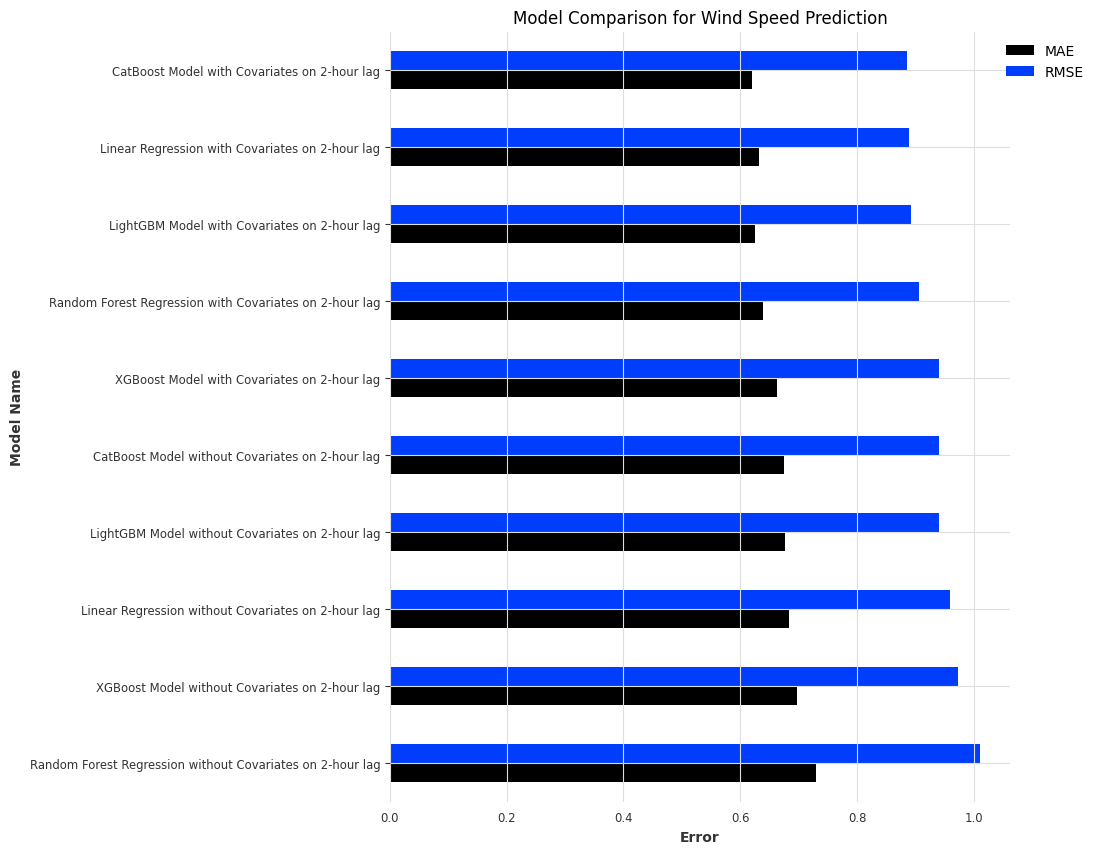

In [ ]:
plot_model_results(model_results, Target="Wind Speed", ax_title="Model Comparison for Wind Speed Prediction")

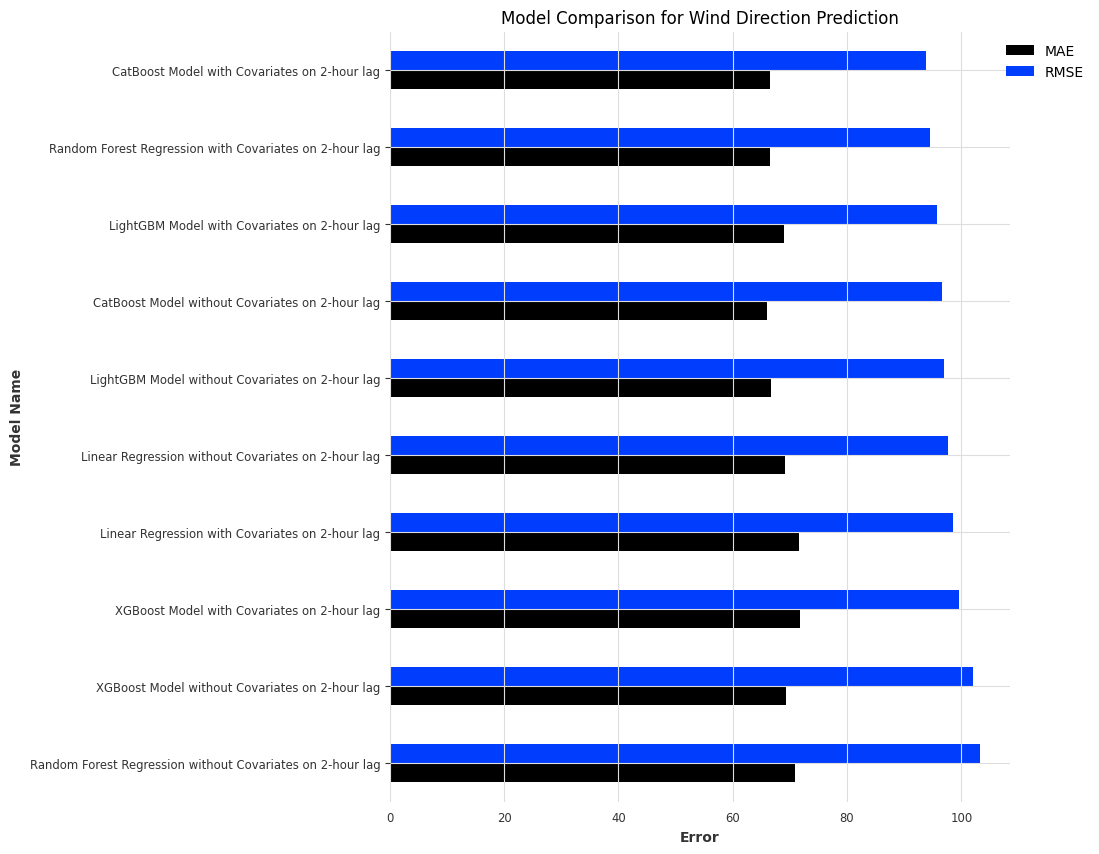

In [ ]:
plot_model_results(model_results, Target="Wind Direction", ax_title="Model Comparison for Wind Direction Prediction")

In [ ]:
def model_elapsed_time(model_results, Target, ax_title):
  # Filter for target
  model_results_ws = model_results[model_results['Target'] == Target]

  # Sort values by RMSE
  model_results_ws_sorted = model_results_ws.sort_values('Elapsed Time(s)', ascending = False)

  # Set plot size
  fig, ax = plt.subplots(figsize=(10, 5))

  # Plot horizontal bar chart
  model_results_ws_sorted.plot(kind='barh', x='Model Name', y='Elapsed Time(s)', ax=ax)

  # Set plot title and axis labels
  ax.set_title(ax_title)
  ax.set_xlabel('Elapsed Time(s)')
  ax.set_ylabel('Model Name')

  # Show plot
  plt.show()

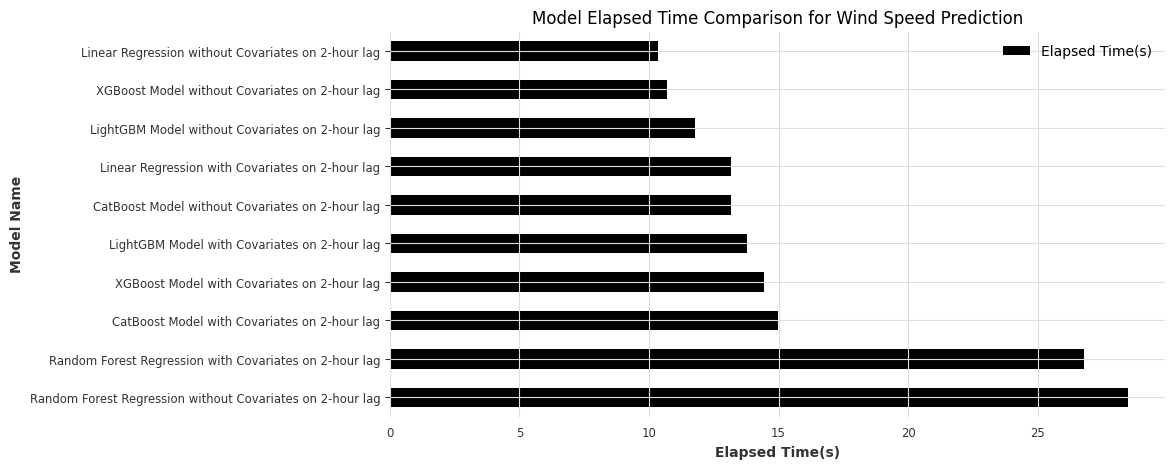

In [ ]:
model_elapsed_time(model_results, Target="Wind Speed", ax_title="Model Elapsed Time Comparison for Wind Speed Prediction")

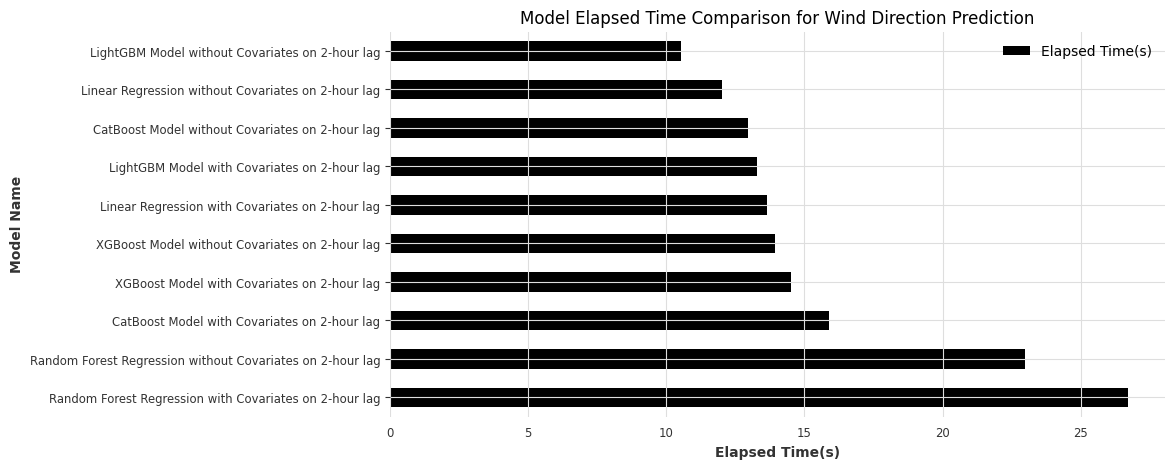

In [ ]:
model_elapsed_time(model_results, Target="Wind Direction", ax_title="Model Elapsed Time Comparison for Wind Direction Prediction")

In [ ]:
# Replace the path with your desired path
path = '/content/drive/MyDrive/DS-ML projects/Predicting Wind Direction and Speed/data'

# Ensure the directory exists, create it if it doesn't
if not os.path.exists(path):
    os.makedirs(path)

model_results.to_csv(os.path.join(path,'model_results with 2-hour lag.csv'), index=False)